In [1]:
import numpy as np
import matplotlib.pyplot as plt
import spikeinterface
import spikeinterface.full as si
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import spikeinterface.postprocessing as sp
import spikeinterface.preprocessing as spre
import spikeinterface.qualitymetrics as qm
#import helper_functions as helper

### load data.raw.h5 file if you want, to get information about the number of channels, shape, and duration of raw recording -- not required for next steps

In [2]:
#Reading the file, BP filtering
local_path= '/mnt/disk20tb/shruti/KCNT1_MEASlices/KCNT1_MEASlices_250606/M07896/Network/000005/data.raw.h5' #network data from chip 16848
recording1 = se.read_maxwell(local_path,stream_id = 'well004') # starts with well000 so make sure to use the right one

freq_min = 300
freq_max = 4500

#recording = si.ConcatenateSegmentRecording([recording1,recording2])
channel_ids = recording1.get_channel_ids()
fs = recording1.get_sampling_frequency()
num_chan = recording1.get_num_channels()
num_seg = recording1.get_num_segments()
total_recording = recording1.get_total_duration()

#print('Channel ids:', channel_ids) 
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print(f"total_recording: {total_recording} s")

recording_bp = spre.bandpass_filter(recording1, freq_min=freq_min, freq_max=freq_max)

recodring_cmr = spre.common_reference(recording_bp, reference='global', operator='median')
#recording_chunk = recodring_cmr.frame_slice(start_frame= 1*fs,end_frame=425*fs)
#recording_chunk = recodring_cmr.frame_slice(start_frame= 0*fs,end_frame=600*fs)
print(f"chunk duration: {recording1.get_total_duration()} s")



Sampling frequency: 10000.0
Number of channels: 899
Number of segments: 1
total_recording: 1200.04 s
chunk duration: 1200.04 s


### load results folder of kilosort4 output, defined as  results_dir

In [293]:
from pathlib import Path

import numpy as np
import pandas as pd

# NOTE: Be sure to update this filepath if you want the data downloaded to
#       a specific location.
#SAVE_PATH = DOWNLOADS_DIR / '.test_data' / 'ZFM-02370_mini.imec0.ap.short.bin'
# outputs saved to results_dir
results_dir = Path("/mnt/disk20tb/shruti/KCNT1_MEASlices/KCNT1_MEASlices_250606/KCNT1_KS4_NoSpicyRun3_W2_Total/")
#ops = load_ops(results_dir / 'ops.npy')
camps = pd.read_csv(results_dir / 'cluster_Amplitude.tsv', sep='\t')['Amplitude'].values
contam_pct = pd.read_csv(results_dir / 'cluster_ContamPct.tsv', sep='\t')['ContamPct'].values
chan_map =  np.load(results_dir / 'channel_map.npy')
templates =  np.load(results_dir / 'templates.npy')
chan_best = (templates**2).sum(axis=1).argmax(axis=-1)
chan_best = chan_map[chan_best]
amplitudes = np.load(results_dir / 'amplitudes.npy')
st = np.load(results_dir / 'spike_times.npy')
clu = np.load(results_dir / 'spike_clusters.npy')
firing_rates = np.unique(clu, return_counts=True)[1] * 30000 / st.max()
#dshift = ops['dshift']

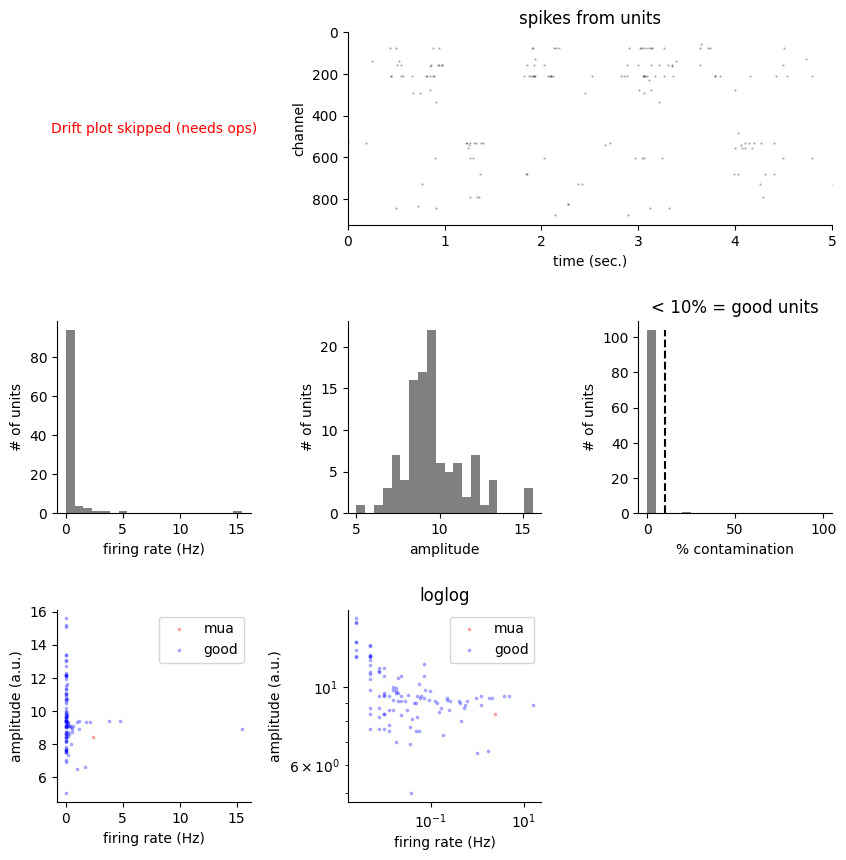

~~~~~~~~~~~~~~ good units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit


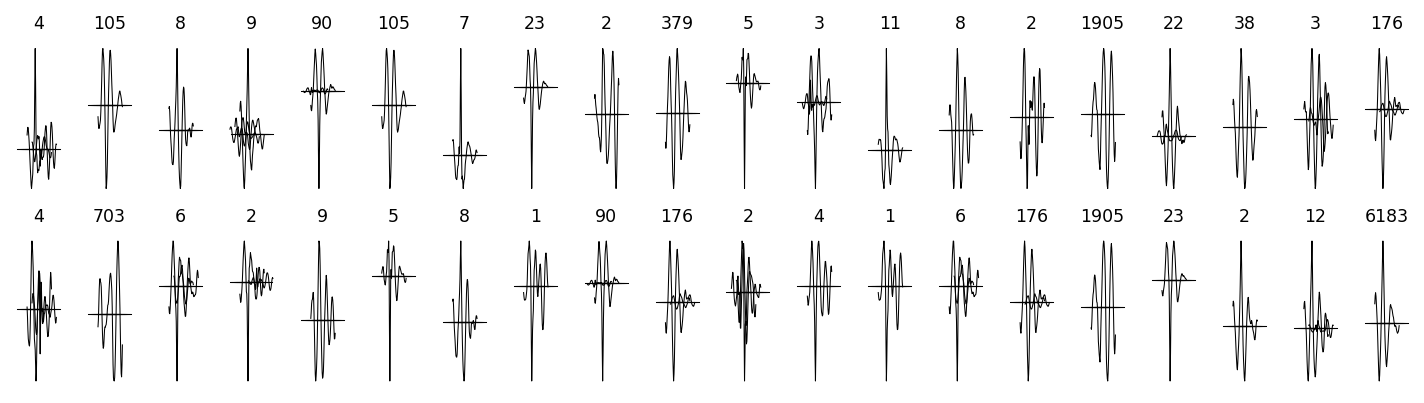

~~~~~~~~~~~~~~ mua units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit


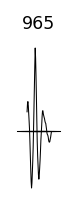

In [294]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec, rcParams
import numpy as np

rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
gray = .5 * np.ones(3)

fig = plt.figure(figsize=(10,10), dpi=100)
grid = gridspec.GridSpec(3, 3, figure=fig, hspace=0.5, wspace=0.5)

# ---- Drift plot (SKIPPED, needs ops) ----
ax = fig.add_subplot(grid[0,0])
ax.text(0.5, 0.5, "Drift plot skipped (needs ops)", 
        ha='center', va='center', fontsize=10, color='red')
ax.set_axis_off()

# ---- Spikes scatter ----
ax = fig.add_subplot(grid[0,1:])
t0 = 0
t1 = np.nonzero(st > 30000*100)[0][0]   # 5 sec worth of spikes
ax.scatter(st[t0:t1]/30000., chan_best[clu[t0:t1]], 
           s=0.5, color='k', alpha=0.25)
ax.set_xlim([0, 5])
ax.set_ylim([chan_map.max(), 0])
ax.set_xlabel('time (sec.)')
ax.set_ylabel('channel')
ax.set_title('spikes from units')

# ---- Histograms ----
ax = fig.add_subplot(grid[1,0])
nb=ax.hist(firing_rates, 20, color=gray)
ax.set_xlabel('firing rate (Hz)')
ax.set_ylabel('# of units')

ax = fig.add_subplot(grid[1,1])
nb=ax.hist(camps, 20, color=gray)
ax.set_xlabel('amplitude')
ax.set_ylabel('# of units')

ax = fig.add_subplot(grid[1,2])
nb=ax.hist(np.minimum(100, contam_pct), np.arange(0,105,5), color=gray)
ax.plot([10, 10], [0, nb[0].max()], 'k--')
ax.set_xlabel('% contamination')
ax.set_ylabel('# of units')
ax.set_title('< 10% = good units')

# ---- Amplitude vs firing rate ----
for k in range(2):
    ax = fig.add_subplot(grid[2,k])
    is_ref = contam_pct < 10.
    ax.scatter(firing_rates[~is_ref], camps[~is_ref], s=3, color='r', label='mua', alpha=0.25)
    ax.scatter(firing_rates[is_ref], camps[is_ref], s=3, color='b', label='good', alpha=0.25)
    ax.set_ylabel('amplitude (a.u.)')
    ax.set_xlabel('firing rate (Hz)')
    ax.legend()
    if k==1:
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title('loglog')

plt.show()

# ---- Waveform plots ----
nc = 16 # number of channels to show
good_units = np.nonzero(contam_pct <= 0.1)[0]
mua_units = np.nonzero(contam_pct > 0.1)[0]

gstr = ['good', 'mua']
for j in range(2):
    print(f'~~~~~~~~~~~~~~ {gstr[j]} units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('title = number of spikes from each unit')
    units = good_units if j==0 else mua_units
    fig = plt.figure(figsize=(12,3), dpi=150)
    grid = gridspec.GridSpec(2,20, figure=fig, hspace=0.25, wspace=0.5)

    for k in range(min(40, len(units))):  # cap at 40 plots
        wi = units[np.random.randint(len(units))]
        wv = templates[wi].copy()
        cb = chan_best[wi]
        nsp = (clu==wi).sum()

        ax = fig.add_subplot(grid[k//20, k%20])
        n_chan = wv.shape[-1]
        ic0 = max(0, cb-nc//2)
        ic1 = min(n_chan, cb+nc//2)
        wv = wv[:, ic0:ic1]

        # Fake probe positions (since ops['probe'] not loaded)
        x0 = np.arange(ic0, ic1)
        y0 = np.zeros_like(x0)

        amp = 4
        for ii, (xi,yi) in enumerate(zip(x0,y0)):
            t = np.arange(-wv.shape[0]//2,wv.shape[0]//2,1,'float32')
            t /= wv.shape[0] / 20
            ax.plot(xi + t, yi + wv[:,ii]*amp, lw=0.5, color='k')

        ax.set_title(f'{nsp}', fontsize='small')
        ax.axis('off')
    plt.show()


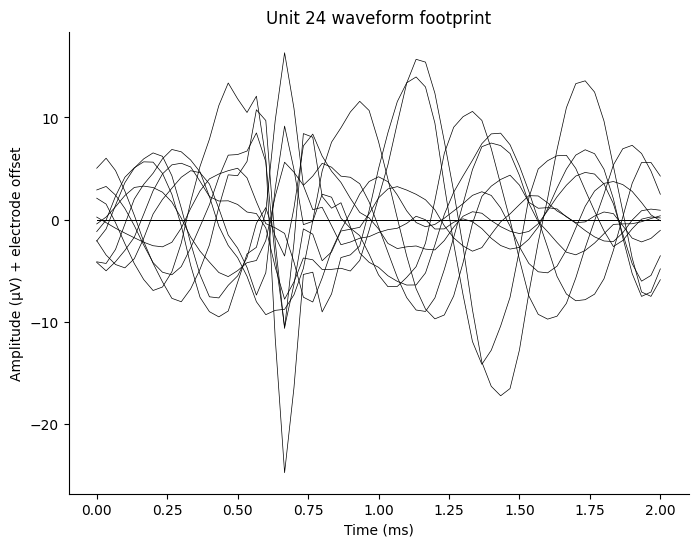

In [295]:
unit = 24 # Set the unit to 11

wv = templates[unit]   # (timepoints x channels)
cb = chan_best[unit]

fs = 30000
time = np.arange(wv.shape[0]) / fs * 1000  # ms
fig, ax = plt.subplots(figsize=(8, 6))

amp_scale = 10  # vertical scaling for clarity
for ch in range(wv.shape[1]):
    trace = wv[:, ch] * amp_scale
    ax.plot(time, trace, lw=0.5, color='k')

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (µV) + electrode offset')  # clearer µV label
ax.set_title(f'Unit {unit} waveform footprint')
plt.show()


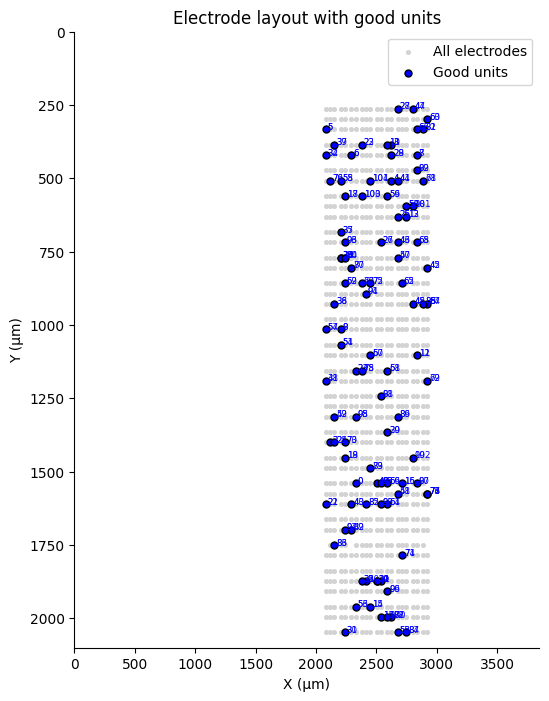

In [296]:
import numpy as np
import matplotlib.pyplot as plt

# Example: suppose you already have these
# locs: (n_channels, 2) array of electrode positions [x,y]
# channel_ids: (n_channels,) list of channel ids
# good_units: indices of good units
# chan_best: best channel index per unit

locs = recording1.get_channel_locations()  # Define locs here

# Plot electrode layout
fig, ax = plt.subplots(figsize=(6,8))
ax.scatter(locs[:,0], locs[:,1], c="lightgray", s=7, label="All electrodes")
# Ensure good_chs only contains valid indices for locs
valid_good_units = good_units[chan_best[good_units] < len(locs)]
good_chs = chan_best[valid_good_units]  # Best channel for each valid good unit

# Overlay good unit positions
good_x = locs[good_chs, 0]
good_y = locs[good_chs, 1]

ax.scatter(good_x, good_y, c="blue", s=25, marker="o", edgecolors="k", label="Good units")

# Annotate each unit with its ID (optional)
for unit, x, y in zip(valid_good_units, good_x, good_y):
    ax.text(x + 15, y, str(unit), fontsize=6.25, color="blue")  # +10 shifts label a bit

# Annotate each unit with its ID (optional)
for unit, x, y in zip(good_units, good_x, good_y):
    ax.text(x+15, y, str(unit), fontsize=6.25, color="blue")  # +10 shifts label a bit
ax.invert_yaxis()   # match typical MEA layout

plt.xlim([0,3850])
plt.ylim(2100,0)
ax.set_title("Electrode layout with good units")
ax.set_xlabel("X (µm)")
ax.set_ylabel("Y (µm)")
ax.legend()
plt.show()


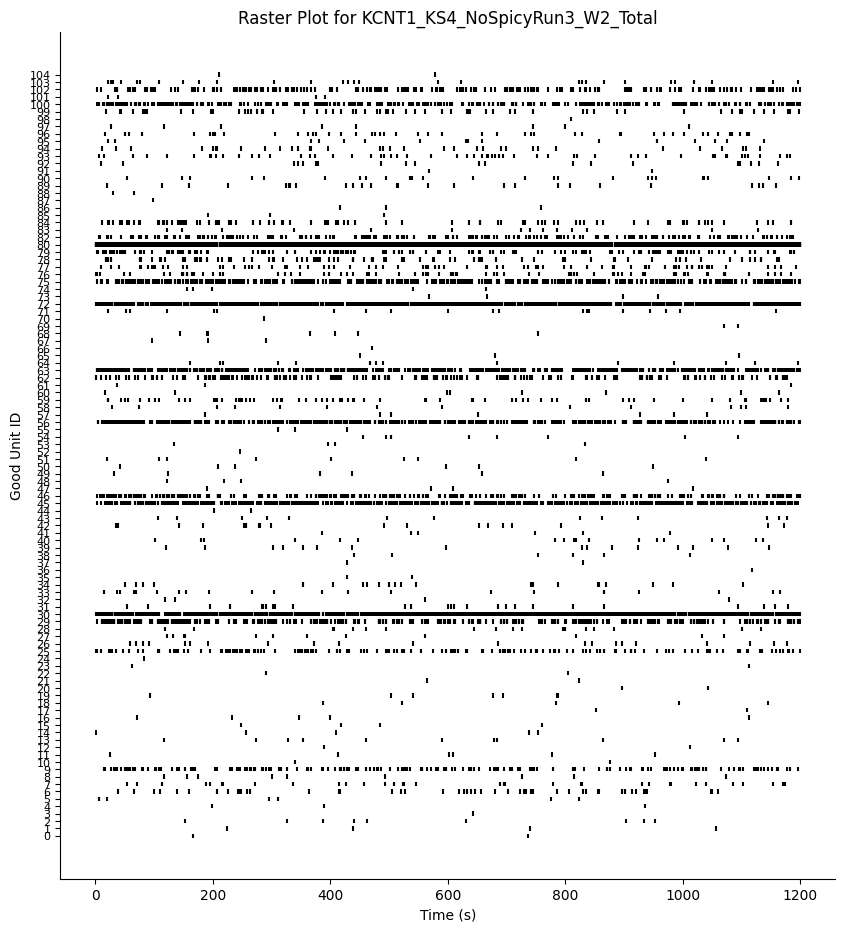

In [297]:
import matplotlib.pyplot as plt
import numpy as np

# Convert spike times to seconds
spike_times_sec = st / 10000.0   # replace 30000 with ops['fs'] if available

# Filter spikes for only good units
mask = np.isin(clu, good_units)
good_spike_times = spike_times_sec[mask]
good_spike_clusters = clu[mask]

# Raster plot
plt.figure(figsize=(10,11))
plt.eventplot(
    [good_spike_times[good_spike_clusters == unit] for unit in good_units],
    colors="black", 
    linelengths=0.6
    
)
plt.yticks(range(len(good_units)), good_units, fontsize=8)  # label y-axis with unit IDs
plt.xlabel("Time (s)")
plt.ylabel("Good Unit ID")
plt.title(f"Raster Plot for {results_dir.name}")  # use last folder in path as title
plt.show()


In [11]:
import numpy as np
import pandas as pd
from pathlib import Path

def compute_qc_metrics(results_dir, fs=30000, refractory_ms=2.0):
    """
    Compute automated QC metrics (Phy-style) for KiloSort outputs.

    Parameters
    ----------
    results_dir : str or Path
        Path to KiloSort output folder.
    fs : float
        Sampling rate in Hz (default: 30 kHz).
    refractory_ms : float
        Refractory period for ISI violation check (default: 2 ms).

    Returns
    -------
    qc_df : pd.DataFrame
        DataFrame of QC metrics per cluster with columns:
        ['cluster_id', 'amplitude', 'contam_pct', 'firing_rate_Hz', 'isi_violations', 'is_good_auto']
    """

    results_dir = Path(results_dir)
    st = np.load(results_dir / 'spike_times.npy')
    clu = np.load(results_dir / 'spike_clusters.npy')

    amps = pd.read_csv(results_dir / 'cluster_Amplitude.tsv', sep='\t')['Amplitude'].values
    contam = pd.read_csv(results_dir / 'cluster_ContamPct.tsv', sep='\t')['ContamPct'].values

    cluster_ids, counts = np.unique(clu, return_counts=True)
    duration_s = st.max() / fs
    firing_rates = counts / duration_s

    # === ISI Violation Rate ===
    isi_violations = []
    refr_frames = refractory_ms * fs / 1000
    for cid in cluster_ids:
        spike_times_cluster = st[clu == cid]
        if len(spike_times_cluster) < 2:
            isi_violations.append(np.nan)
            continue
        isis = np.diff(spike_times_cluster)
        violation_rate = np.sum(isis < refr_frames) / len(isis)
        isi_violations.append(violation_rate)

    isi_violations = np.array(isi_violations)

    # Align array lengths if needed (for truncated files)
    n = min(len(cluster_ids), len(amps), len(contam))
    cluster_ids = cluster_ids[:n]
    amps = amps[:n]
    contam = contam[:n]
    firing_rates = firing_rates[:n]
    isi_violations = isi_violations[:n]

    # === QC thresholds (tuned to typical Phy-like criteria) ===
    amp_thresh = np.median(amps) * 0.5         # amplitude > 50% of median
    contam_thresh = 20                         # < 20% contamination
    isi_thresh = 0.02                          # < 2% ISI violations
    fr_thresh = 0.1                            # > 0.1 Hz firing rate

    is_good_auto = (
        (amps > amp_thresh)
        & (contam < contam_thresh)
        & (firing_rates > fr_thresh)
        & (isi_violations < isi_thresh)
    )

    # Combine into DataFrame
    qc_df = pd.DataFrame({
        'cluster_id': cluster_ids,
        'amplitude': amps,
        'contam_pct': contam,
        'firing_rate_Hz': firing_rates,
        'isi_violations': isi_violations,
        'is_good_auto': is_good_auto
    })

    print(f"Auto-labeled {qc_df['is_good_auto'].sum()} / {len(qc_df)} clusters as 'good'.")
    return qc_df


In [12]:
qc_df = compute_qc_metrics(results_dir)

# Print the good ones
good_units = qc_df.loc[qc_df['is_good_auto'], 'cluster_id'].values
print("Good units:", good_units)

qc_df = qc_df.sort_values(by='amplitude', ascending=False)
# View QC summary
qc_df.head()


Auto-labeled 24 / 105 clusters as 'good'.
Good units: [  6   9  25  29  30  45  46  56  59  62  63  72  75  76  77  78  79  82
  84  93  96  99 100 102]


cluster_id  amplitude  contam_pct  firing_rate_Hz  isi_violations  \
66          66       15.6         0.0          0.0025             NaN   
70          70       15.2         0.0          0.0025             NaN   
87          87       15.1         0.0          0.0025             NaN   
52          52       13.4         0.0          0.0025             NaN   
24          24       13.4         0.0          0.0025             NaN   

    is_good_auto  
66         False  
70         False  
87         False  
52         False  
24         False

### TESTING NEW PROBE MATCHING 

In [143]:
'''take probe layout map and match it to spicy acsf using brute force approach 
- create circle around 9 units and use transparency for other electrodes 
- all spikes from that waveform, display 
- average waveform for that unit
-- add stats for the comparison 
-  so for all matched '''

'take probe layout map and match it to spicy acsf using brute force approach \n- create circle around 9 units and use transparency for other electrodes \n- all spikes from that waveform, display \n- average waveform for that unit\n-- add stats for the comparison \n-  so for all matched '

## START OF COMPARITIVE ANALYSIS

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

fs = recording1.get_sampling_frequency()  # or your actual sampling rate
def get_unit_spikes(spike_times, spike_clusters, unit_id):
    """Return spike times (in seconds) for a given unit."""
    mask = spike_clusters == unit_id
    return spike_times[mask] / fs  # assuming fs=30 kHz


def load_kilosort_data(folder):
    """Load essential Kilosort outputs from a folder."""
    folder = Path(folder)
    data = {}
    data['chan_map'] = np.load(folder / 'channel_map.npy')
    data['templates'] = np.load(folder / 'templates.npy')
    data['amplitudes'] = np.load(folder / 'amplitudes.npy')
    data['spike_times'] = np.load(folder / 'spike_times.npy')
    data['spike_clusters'] = np.load(folder / 'spike_clusters.npy')
    data['channel_positions'] = np.load(folder / 'channel_positions.npy')  

    # Optional cluster info TSVs (if they exist)
    try:
        data['amplitude_stats'] = pd.read_csv(folder / 'cluster_Amplitude.tsv', sep='\t')['Amplitude'].values
        data['contam_pct'] = pd.read_csv(folder / 'cluster_ContamPct.tsv', sep='\t')['ContamPct'].values
    except FileNotFoundError:
        print(f"⚠️ cluster_Amplitude.tsv or cluster_ContamPct.tsv not found in {folder}")
        data['amplitude_stats'] = None
        data['contam_pct'] = None

    # Compute best channel per template (largest energy)
    chan_best = (data['templates']**2).sum(axis=1).argmax(axis=-1)
    data['chan_best'] = data['chan_map'][chan_best]

    # Firing rate (Hz)
    data['firing_rates'] = np.unique(data['spike_clusters'], return_counts=True)[1] * 30000 / data['spike_times'].max()
    return data


In [21]:
path_spicy = Path("/mnt/disk20tb/shruti/KCNT1_MEASlices/KCNT1_MEASlices_250606/KCNT1_KS4_SpicyRun5_Total/")
path_no_spicy = Path("/mnt/disk20tb/shruti/KCNT1_MEASlices/KCNT1_MEASlices_250606/KCNT1_KS4_NoSpicyRun3_W5_Total/kilosort4/")

rec1 = load_kilosort_data(path_no_spicy)
rec2 = load_kilosort_data(path_spicy)
#Convert from volts (kilosort default) to microvolts
rec1['amplitude_stats'] = rec1['amplitude_stats'] * 1000
rec2['amplitude_stats'] = rec2['amplitude_stats'] * 1000 


locs = recording1.get_channel_locations()
amp_thr = 2000 # µV
contam_thr = 10  # %

good_units_1 = np.where((rec1['amplitude_stats'] > amp_thr) & (rec1['contam_pct'] < contam_thr))[0]
good_units_2 = np.where((rec2['amplitude_stats'] > amp_thr) & (rec2['contam_pct'] < contam_thr))[0]

print(f"Good units: {len(good_units_1)} in No-Spicy, {len(good_units_2)} in Spicy")


Good units: 93 in No-Spicy, 91 in Spicy


In [22]:
matched_units = []

for u1 in good_units_1:
    ch1 = rec1['chan_best'][u1]
    matches = np.where(rec2['chan_best'][good_units_2] == ch1)[0]
    if len(matches) > 0:
        for m in matches:
            matched_units.append((u1, good_units_2[m], ch1))

matched_units = np.array(matched_units)
print(f"Matched units: {len(matched_units)}")


Matched units: 25


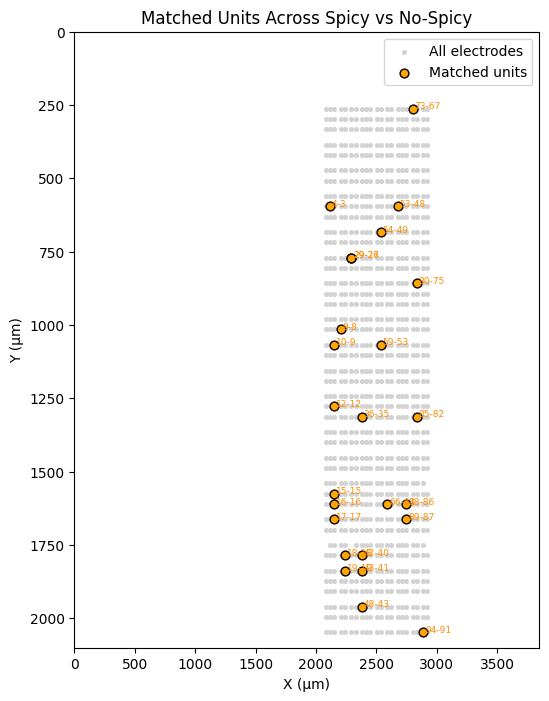

In [23]:
fig, ax = plt.subplots(figsize=(6,8))

# Plot all electrodes faintly
ax.scatter(locs[:,0], locs[:,1], c="lightgray", s=7, label="All electrodes")

# Plot matched electrode positions
matched_chs = matched_units[:,2].astype(int)
ax.scatter(locs[matched_chs,0], locs[matched_chs,1],
           c="orange", s=40, edgecolors="k", label="Matched units")

# Annotate matched units
for (u1, u2, ch) in matched_units:
    x, y = locs[int(ch)]
    ax.text(x+15, y, f"{u1}-{u2}", fontsize=6.5, color="darkorange")

ax.invert_yaxis()
plt.xlim([0,3850])
plt.ylim(2100,0)
ax.set_title("Matched Units Across Spicy vs No-Spicy")
ax.set_xlabel("X (µm)")
ax.set_ylabel("Y (µm)")
ax.legend()
plt.show()


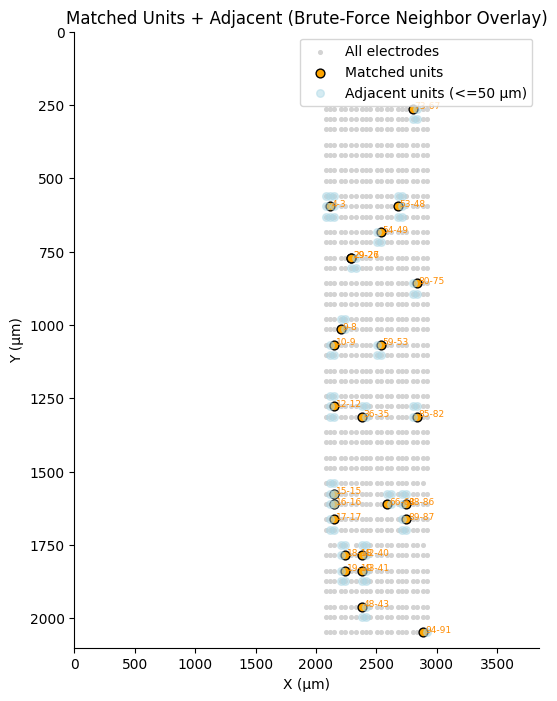

In [288]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 8))

# Base electrode layout
ax.scatter(locs[:, 0], locs[:, 1], c="lightgray", s=7, label="All electrodes")

# Matched electrodes (main orange dots)
matched_chs = matched_units[:, 2].astype(int)
ax.scatter(
    locs[matched_chs, 0],
    locs[matched_chs, 1],
    c="orange",
    s=40,
    edgecolors="k",
    label="Matched units"
)

# Compute and plot adjacent units (within distance threshold)
adjacent_radius = 50  # µm
adjacent_chs = []

for (u1, u2, ch) in matched_units:
    x, y = locs[int(ch)]
    # compute distance to all channels
    dists = np.linalg.norm(locs - np.array([x, y]), axis=1)
    neighbors = np.where((dists <= adjacent_radius) & (dists > 0))[0]
    adjacent_chs.extend(neighbors)

adjacent_chs = np.unique(adjacent_chs)  # remove duplicates

# Plot adjacent channels with 50% opacity
ax.scatter(
    locs[adjacent_chs, 0],
    locs[adjacent_chs, 1],
    c="lightblue",
    s=30,
    alpha=0.5,
    label=f"Adjacent units (<={adjacent_radius} µm)"
)

# Annotate main matched pairs
for (u1, u2, ch) in matched_units:
    x, y = locs[int(ch)]
    ax.text(x + 15, y, f"{u1}-{u2}", fontsize=6.5, color="darkorange")

# Formatting
ax.invert_yaxis()
plt.xlim([0, 3850])
plt.ylim(2100, 0)
ax.set_title("Matched Units + Adjacent (Brute-Force Neighbor Overlay)")
ax.set_xlabel("X (µm)")
ax.set_ylabel("Y (µm)")
ax.legend()
plt.show()


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# ---------- Utilities ----------
def cosine_similarity(a, b):
    a = a - np.mean(a)
    b = b - np.mean(b)
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    return (np.dot(a, b) / denom) if denom != 0 else 0.0

def dtw_cost(a, b, dist_fn=lambda x,y: (x-y)**2):
    """
    Classic DTW: returns (cost, path_length) where cost is total accumulated cost.
    Uses O(N*M) time and memory (templates are small so it's fine).
    """
    n = len(a); m = len(b)
    # cost matrix with +inf padding
    D = np.full((n+1, m+1), np.inf, dtype=float)
    D[0,0] = 0.0
    for i in range(1, n+1):
        ai = a[i-1]
        for j in range(1, m+1):
            bj = b[j-1]
            cost = dist_fn(ai, bj)
            D[i,j] = cost + min(D[i-1,j],    # insertion
                                D[i,j-1],    # deletion
                                D[i-1,j-1])  # match
    return D[n,m]

# ---------- Neighborhood selectors ----------
def nearby_channels_by_radius(chan_pos, center_idx, radius_um):
    """
    Return indices of channels within Euclidean distance <= radius_um (including center).
    chan_pos: [n_channels,2] array of (x,y)
    center_idx: index of central channel
    """
    center = chan_pos[center_idx]
    dists = np.linalg.norm(chan_pos - center, axis=1)
    return np.where(dists <= radius_um)[0]

def nearby_channels_k_nearest(chan_pos, center_idx, k):
    """
    Return indices of k nearest channels (including center).
    """
    dists = np.linalg.norm(chan_pos - chan_pos[center_idx], axis=1)
    order = np.argsort(dists)
    return order[:k]

# ---------- Core matching function ----------
def match_within_neighborhood_dtw(rec1, rec2, matched_units,
                                   radius_um=None, k_nearest=None,
                                   use_cosine_also=True, dtw_dist_fn=None):
    """
    For each matched pair (u1, u2, ch), find the best matching channel on rec2 within a neighborhood
    based on DTW cost between single-channel templates.
    - rec1/rec2: dicts with 'templates' (n_units, t, n_ch), 'chan_map' (n_ch,), 'channel_positions' (n_ch,2), 'chan_best'
    - matched_units: array-like of (u1, u2, ch)
    - radius_um: if set, use channels within this physical radius (preferred)
    - k_nearest: if set, use k nearest channels (alternative). If both given, radius_um takes precedence.
    Returns:
      new_matches: list of tuples (u1, u2, ch1_best, best_ch2_idx, dtw_cost, cos_sim)
    """
    templates1 = rec1['templates']
    templates2 = rec2['templates']
    chan_map2 = rec2['chan_map']  # maps indices -> channel ids (if needed)
    chan_pos2 = rec2['channel_positions']
    chan_best2 = rec2['chan_best']

    new_matches = []
    for (u1, u2, ch) in matched_units:
        u1 = int(u1); u2 = int(u2)
        ch1_best = rec1['chan_best'][u1]  # physical channel id
        # need index in templates arrays (templates arrays assumed indexed by channel index, not physical channel id)
        # If chan_map stores mapping from template-channel-index -> physical channel id,
        # we must convert phys->index. Let's build an index map:
        # (Do once outside loop in caller ideally)
        # Here we compute it on-the-fly:
        chan_index_map = {phys: idx for idx, phys in enumerate(rec2['chan_map'])}
        chan_index_map1 = {phys: idx for idx, phys in enumerate(rec1['chan_map'])}

        idx1 = chan_index_map1[int(ch1_best)]
        # Reference waveform in rec1 (single-channel)
        wv1 = templates1[u1, :, idx1]

        # center for searching in rec2 = rec2['chan_best'][u2] physical id -> index
        center_phys = int(rec2['chan_best'][u2])
        center_idx2 = chan_index_map[center_phys]

        # find neighbor indices (indices into templates2 channels)
        if radius_um is not None:
            neighbor_idx = nearby_channels_by_radius(chan_pos2, center_idx2, radius_um)
        elif k_nearest is not None:
            neighbor_idx = nearby_channels_k_nearest(chan_pos2, center_idx2, k_nearest)
        else:
            # default: 7x7-ish neighborhood by nearest 25 channels
            neighbor_idx = nearby_channels_k_nearest(chan_pos2, center_idx2, 25)

        # search best by DTW
        best_cost = np.inf
        best_idx = None
        best_cos = -1.0

        for cidx in neighbor_idx:
            wv2 = templates2[u2, :, cidx]
            # optionally normalize or center:
            a = (wv1 - np.mean(wv1))
            b = (wv2 - np.mean(wv2))
            # compute dtw cost
            cost = dtw_cost(a, b, dist_fn=lambda x,y: (x-y)**2)  # returns accumulated squared error
            cos = cosine_similarity(a, b) if use_cosine_also else None

            # pick best by DTW cost (lowest)
            if cost < best_cost:
                best_cost = cost
                best_idx = cidx
                best_cos = cos

        # store physical channel ids for returned tuple (convert indices back to phys)
        best_phys = int(rec2['chan_map'][best_idx])
        new_matches.append((u1, u2, int(ch1_best), best_phys, float(best_cost), float(best_cos)))

    return np.array(new_matches, dtype=object)

# ---------- Example invocation ----------
# Parameters you can tune:
# - radius_um = 3 * electrode_spacing (if you know spacing) OR supply k_nearest
# Let's use k_nearest = 9**  (3 electrodes each side in a small 2D neighborhood)
#
# Suppose electrode spacing is ~20 µm vertically; for a "3-electrode radius" vertically that's 60 µm.
# If you prefer exact channels count, use k_nearest (e.g., 25).
#
# Example:
# new_matches = match_within_neighborhood_dtw(rec1, rec2, matched_units, radius_um=60)
# or
# new_matches = match_within_neighborhood_dtw(rec1, rec2, matched_units, k_nearest=25)

# ---------- Plotting the results on the probe map ----------
def plot_matched_map_with_dtw(locs, matched_units, new_matches):
    """
    locs: [n_channels,2] in phys coords (same as rec2['channel_positions'] or a global loc array indexed by physical channel id)
    matched_units: original matched list (u1,u2,ch_phys)
    new_matches: result rows (u1,u2,ch1_phys,best_ch2_phys,dtw_cost,cos)
    """
    fig, ax = plt.subplots(figsize=(7,8))
    ax.scatter(locs[:,0], locs[:,1], c='lightgray', s=7, label='All electrodes')

    # original matched centers
    orig_chs = np.array([int(x[2]) for x in matched_units]).astype(int)
    ax.scatter(locs[orig_chs,0], locs[orig_chs,1], c='orange', s=40, edgecolors='k', label='Original matched')

    # best channels found by DTW
    best_chs = np.array([int(x[3]) for x in new_matches]).astype(int)
    ax.scatter(locs[best_chs,0], locs[best_chs,1], c='red', s=50, marker='X', edgecolors='k', label='Best by DTW')

    # draw lines from original to chosen best
    for (u1, u2, ch1, ch2, cost, cos) in new_matches:
        p1 = locs[int(ch1)]
        p2 = locs[int(ch2)]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='gray', linewidth=0.8, alpha=0.7)

    # annotate a few (optional)
    for (u1, u2, ch1, ch2, cost, cos) in new_matches:
        x, y = locs[int(ch2)]
        ax.text(x+10, y, f"{u1}-{u2}\nDTW={cost:.1f}\ncos={cos:.2f}", fontsize=6, color='darkred')

    ax.invert_yaxis()
    ax.set_xlim([locs[:,0].min()-50, locs[:,0].max()+50])
    ax.set_ylim(locs[:,1].max()+50, locs[:,1].min()-50)
    ax.set_xlabel('X (µm)')
    ax.set_ylabel('Y (µm)')
    ax.set_title("DTW-based best neighbor matches")
    ax.legend()
    plt.xlim([0,3850])
    plt.ylim(2100,0)
    plt.tight_layout()
    plt.show()

# ---------- Small note on mapping indices/physical channel ids ----------
# The code above assumes:
# - recX['chan_map'] maps channel-index->physical channel id which are used in locs indexing.
# - recX['channel_positions'] is ordered in the same index order as recX['chan_map'].
# If your `locs` variable is indexed by physical channel id (e.g., locs[phys_id] -> (x,y)),
# ensure consistent mapping or create a mapping dict: phys->pos_idx.


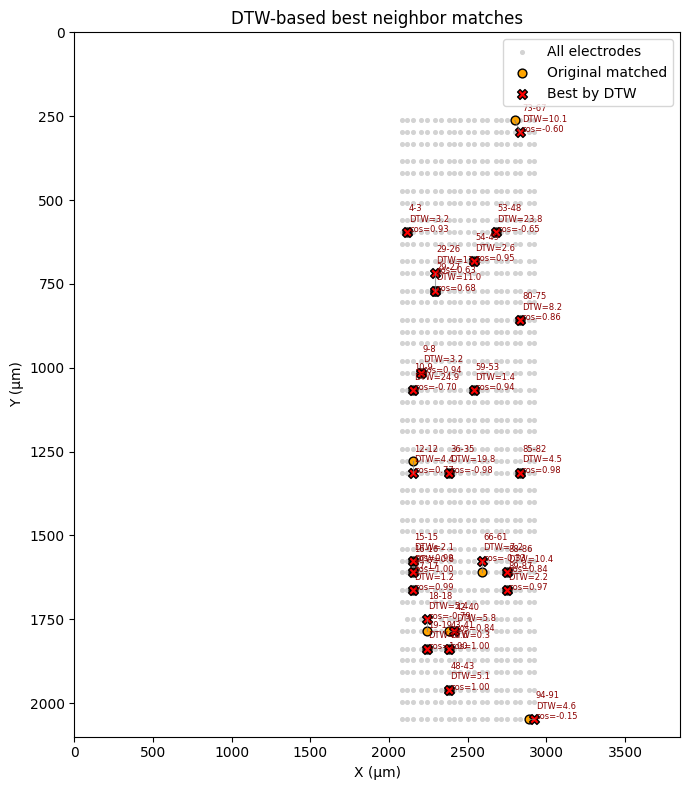

In [27]:
new_matches = match_within_neighborhood_dtw(rec1, rec2, matched_units, radius_um=60)
plot_matched_map_with_dtw(locs, matched_units, new_matches)


In [36]:
def to_1d(arr):
    """Ensure input is 1D, raise informative error if not."""
    arr = np.array(arr)
    arr = np.squeeze(arr)  # remove singleton dims
    if arr.ndim != 1:
        raise ValueError(f"Waveform is not 1D after squeeze! Shape: {arr.shape}")
    return arr

def best_neighbor_waveform_match_dtw(rec1, rec2, matched_units, radius_um=40):
    locs2 = rec2['channel_positions']
    new_matches = []
    similarity_scores = []

    for (u1, u2, ch) in matched_units:
        ch1_best = rec1['chan_best'][u1]
        wv1 = to_1d(rec1['templates'][u1, :, ch1_best])
        
        ch2_best = rec2['chan_best'][u2]
        x2, y2 = locs2[ch2_best]
        dists = np.linalg.norm(locs2 - np.array([x2, y2]), axis=1)
        nearby_chs = np.where(dists <= radius_um)[0]

        best_score = -np.inf
        best_ch2 = None
        for ch_near in nearby_chs:
            wv2 = to_1d(rec2['templates'][u2, :, ch_near])
            sim = dtw_similarity(wv1, wv2)
            if sim > best_score:
                best_score = sim
                best_ch2 = ch_near

        new_matches.append((u1, u2, ch1_best, best_ch2))
        similarity_scores.append(best_score)
    
    return np.array(new_matches, dtype=object), np.array(similarity_scores)


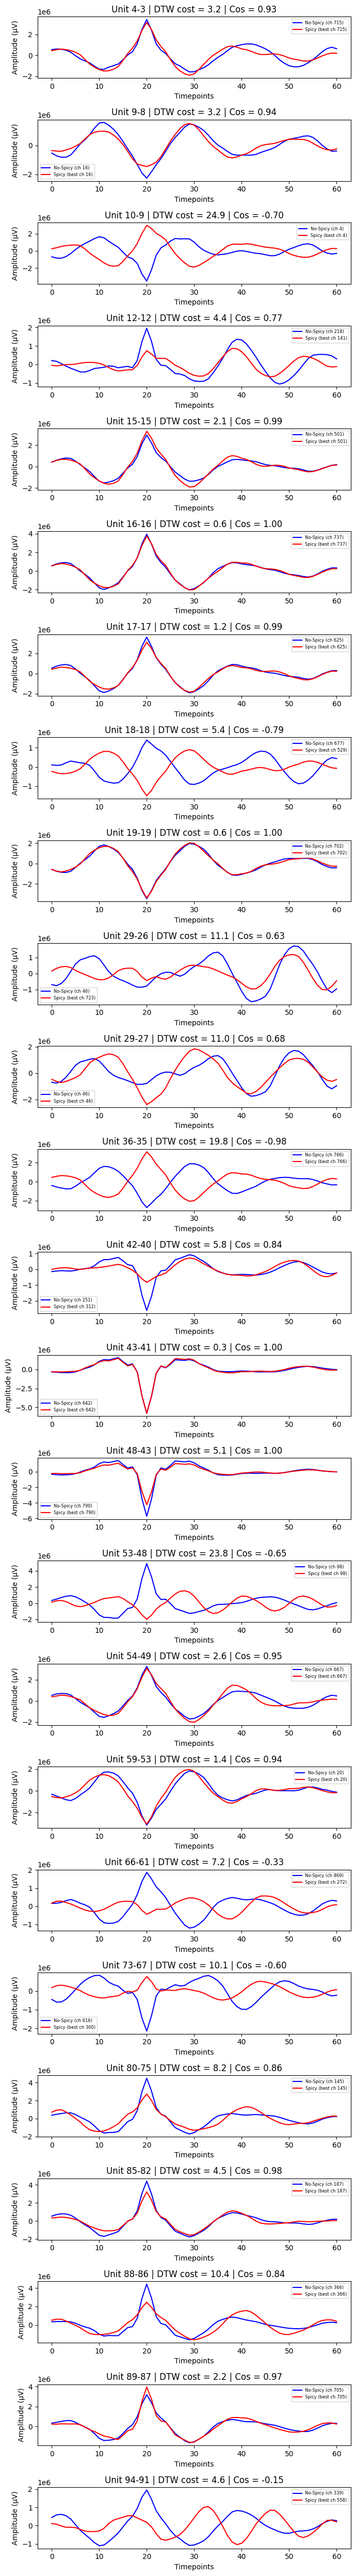

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

# ---------- DTW similarity ----------
def dtw_cost(a, b, dist_fn=lambda x, y: (x - y)**2):
    """Classic DTW cost (accumulated squared error)."""
    a = a.ravel()
    b = b.ravel()
    n, m = len(a), len(b)
    D = np.full((n+1, m+1), np.inf)
    D[0, 0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = dist_fn(a[i-1], b[j-1])
            D[i, j] = cost + min(D[i-1, j], D[i, j-1], D[i-1, j-1])
    return D[n, m]

# ---------- Plotting waveforms using DTW-selected channels ----------
def plot_best_waveforms_dtw(rec1, rec2, dtw_matches):
    """
    dtw_matches: array-like of (u1, u2, ch1_phys, best_ch2_phys, dtw_cost, cosine)
    """
    n_units = len(dtw_matches)
    fig, axes = plt.subplots(n_units, 1, figsize=(7, 2 * n_units))
    if n_units == 1:
        axes = [axes]

    # Build reverse maps: physical channel id -> index in templates
    chan_map1_inv = {phys: idx for idx, phys in enumerate(rec1['chan_map'])}
    chan_map2_inv = {phys: idx for idx, phys in enumerate(rec2['chan_map'])}

    for i, (u1, u2, ch1_phys, ch2_phys, dtw_val, cos_val) in enumerate(dtw_matches):
        idx1 = chan_map1_inv[int(ch1_phys)]
        idx2 = chan_map2_inv[int(ch2_phys)]

        wv1 = rec1['templates'][int(u1), :, idx1] * 1e6
        wv2 = rec2['templates'][int(u2), :, idx2] * 1e6

        ax = axes[i]
        ax.plot(wv1, color='blue', label=f'No-Spicy (ch {ch1_phys})')
        ax.plot(wv2, color='red', label=f'Spicy (best ch {ch2_phys})')
        ax.set_title(f"Unit {u1}-{u2} | DTW cost = {dtw_val:.1f} | Cos = {cos_val:.2f}")
        ax.set_xlabel("Timepoints")
        ax.set_ylabel("Amplitude (µV)")
        ax.legend(fontsize=6)

    plt.tight_layout()
    plt.show()

# Suppose `new_matches` comes from your DTW-based matching:
# (u1, u2, ch1_phys, best_ch2_phys, dtw_cost, cosine_similarity)
plot_best_waveforms_dtw(rec1, rec2, new_matches)


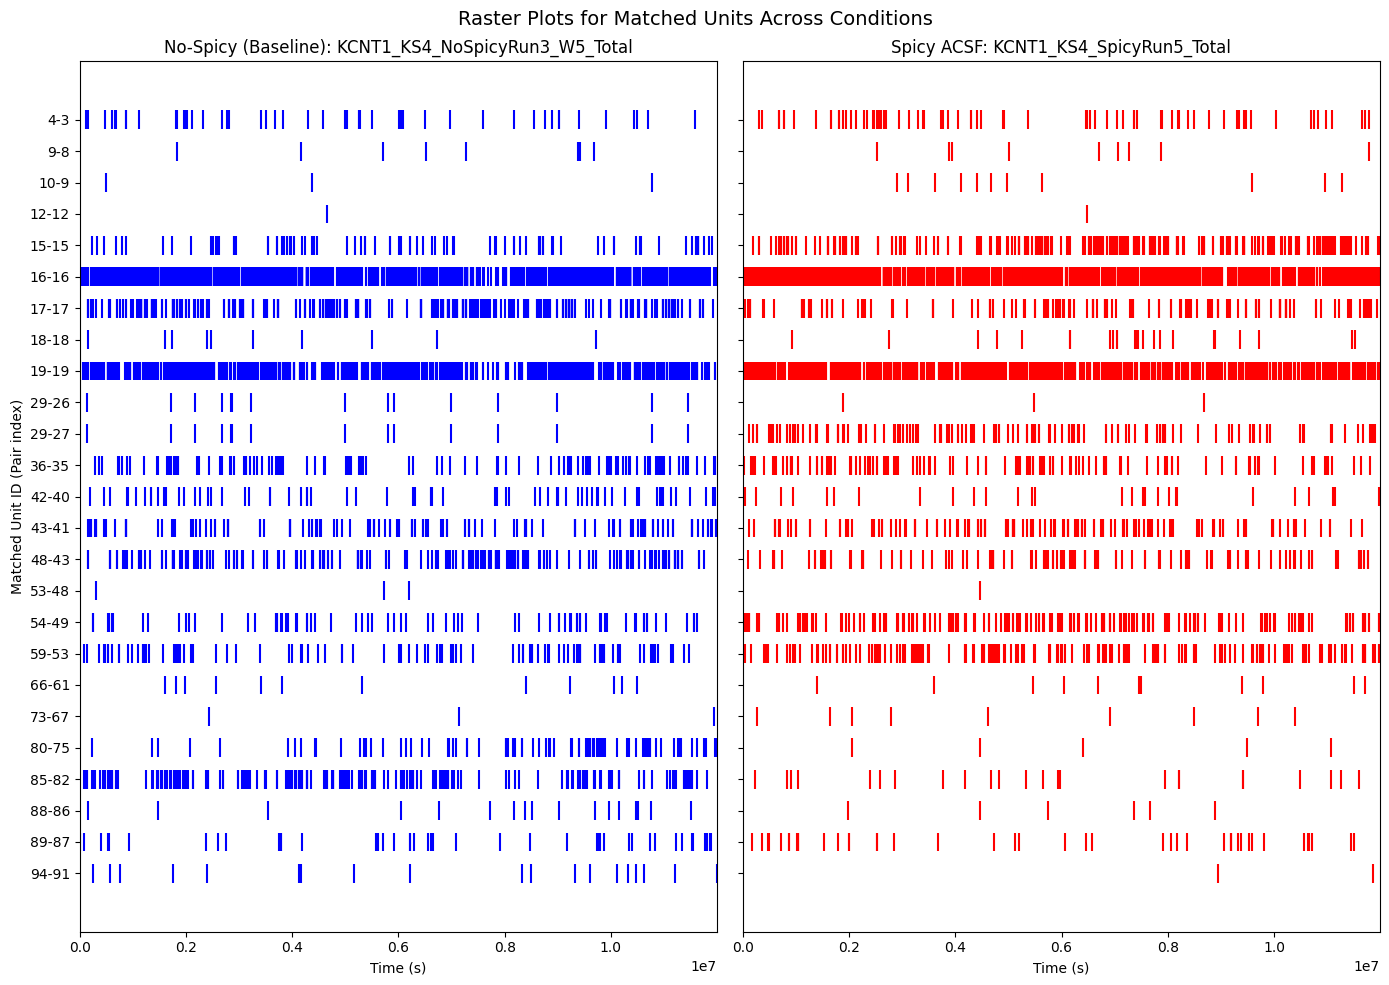

No-Spicy recording duration: 11993827.00 s
Spicy recording duration: 11989567.00 s


In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Filter to matched units only (from your DTW matches)
# Assuming new_matches contains: (u1, u2, ch1_phys, best_ch2_phys, dtw_cost, cosine)
matched_units_list = [(int(u1), int(u2)) for u1, u2, _, _, _, _ in new_matches]
matched_units_list = matched_units_list[::-1]
fig, axes = plt.subplots(1, 2, figsize=(14, 10), sharey=True)

# Get total duration for x-axis limits
duration_1 = rec1['spike_times'].max() if len(rec1['spike_times']) > 0 else 1200
duration_2 = rec2['spike_times'].max() if len(rec2['spike_times']) > 0 else 1200
max_duration = max(duration_1, duration_2)

# ---- Left: No-Spicy ----
for i, (u1, u2) in enumerate(matched_units_list):
    times_1 = get_unit_spikes(rec1['spike_times'], rec1['spike_clusters'], u1)
    axes[0].eventplot(times_1, lineoffsets=i, colors="blue", linelengths=0.6)

axes[0].set_title(f"No-Spicy (Baseline): {path_no_spicy.parts[-2]}")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Matched Unit ID (Pair index)")
axes[0].set_yticks(range(len(matched_units_list)))
axes[0].set_yticklabels([f"{u1}-{u2}" for (u1, u2) in matched_units_list])
axes[0].set_xlim(0, max_duration)

# ---- Right: Spicy ----
for i, (u1, u2) in enumerate(matched_units_list):
    times_2 = get_unit_spikes(rec2['spike_times'], rec2['spike_clusters'], u2)
    axes[1].eventplot(times_2, lineoffsets=i, colors="red", linelengths=0.6)

axes[1].set_title(f"Spicy ACSF: {path_spicy.name}")
axes[1].set_xlabel("Time (s)")
axes[1].set_xlim(0, max_duration)

plt.suptitle(f"Raster Plots for Matched Units Across Conditions", fontsize=14)
plt.tight_layout()
plt.show()

# Print recording durations for verification
print(f"No-Spicy recording duration: {duration_1:.2f} s")
print(f"Spicy recording duration: {duration_2:.2f} s")

In [48]:
import pandas as pd
from io import BytesIO
import base64
from IPython.core.display import HTML

# Create a DataFrame with unit pairs and firing rates
firing_rate_df = pd.DataFrame({
    'Unit Pair': [f'{u1}-{u2}' for u1, u2, *_ in matched_units],
    'No-Spicy Firing Rate (Hz)': [rec1['firing_rates'][u1] for u1, u2, *_ in matched_units],
    'Spicy Firing Rate (Hz)': [rec2['firing_rates'][u2] for u1, u2, *_ in matched_units]
})

# Display the DataFrame
firing_rate_df

Unit Pair  No-Spicy Firing Rate (Hz)  Spicy Firing Rate (Hz)
0        4-3                   0.125064                0.187663
1        9-8                   0.020010                0.022520
2       10-9                   0.007504                0.027524
3      12-12                   0.002501                0.002502
4      15-15                   0.227617                0.840731
5      16-16                   5.582872                5.402197
6      17-17                   0.910468                0.382833
7      18-18                   0.025013                0.060052
8      19-19                   1.966011                2.412097
9      29-26                   0.037519                0.007507
10     29-27                   0.037519                0.332789
11     36-35                   0.272640                0.300261
12     42-40                   0.172589                0.072563
13     43-41                   0.347679                0.352807
14     48-43                   0.542779                0.305265
15     53-48                   0.007504                0.002502
16     54-49                   0.192599                0.462902
17     59-53                   0.245126                0.425370
18     66-61                   0.030015                0.027524
19     73-67                   0.007504                0.022520
20     80-75                   0.212609                0.012511
21     85-82                   0.552784                0.060052
22     88-86                   0.042522                0.015013
23     89-87                   0.107555                0.110096
24     94-91                   0.047524                0.005004


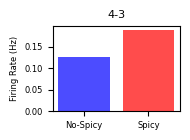
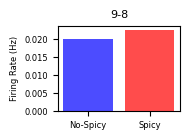
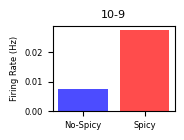
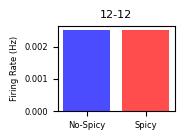
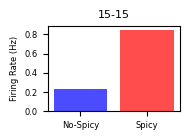
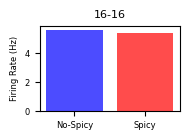
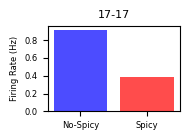
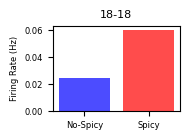
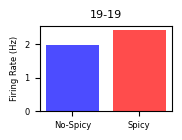
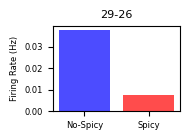
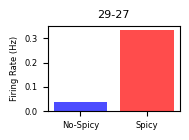
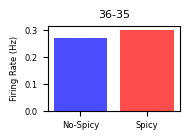
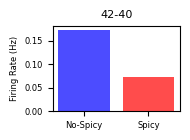
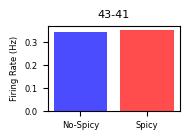
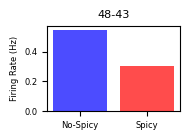
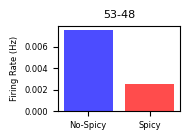
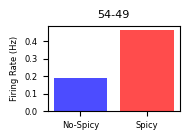
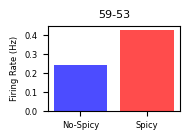
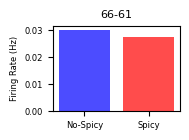
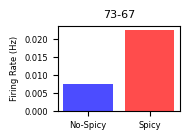
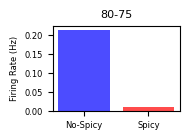
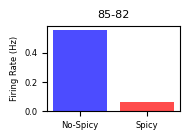
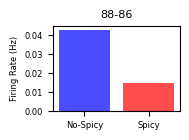
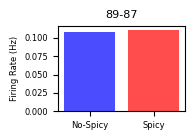
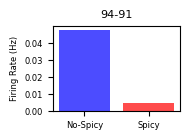

In [ ]:

import matplotlib.pyplot as plt

# Function to create a bar plot for each row
def create_bar_plot(row):
    fig, ax = plt.subplots(figsize=(2, 1.5))
    ax.bar(['No-Spicy', 'Spicy'], [row['No-Spicy Firing Rate (Hz)'], row['Spicy Firing Rate (Hz)']],
           color=['blue', 'red'], alpha=0.7)
    ax.set_ylabel('Firing Rate (Hz)', fontsize=6)
    ax.set_title(row['Unit Pair'], fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=6)
    plt.tight_layout()

    # Save the plot to a BytesIO object
    buf = BytesIO()
    plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
    plt.close(fig)
    buf.seek(0)
    return f'<img src="data:image/png;base64,{base64.b64encode(buf.read()).decode("utf-8")}" />'

# Add a column with the bar plot for each row
firing_rate_df['Bar Plot'] = firing_rate_df.apply(create_bar_plot, axis=1)

# Display the DataFrame with bar plots
HTML(firing_rate_df.to_html(escape=False))



/tmp/ipykernel_19/1648887484.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


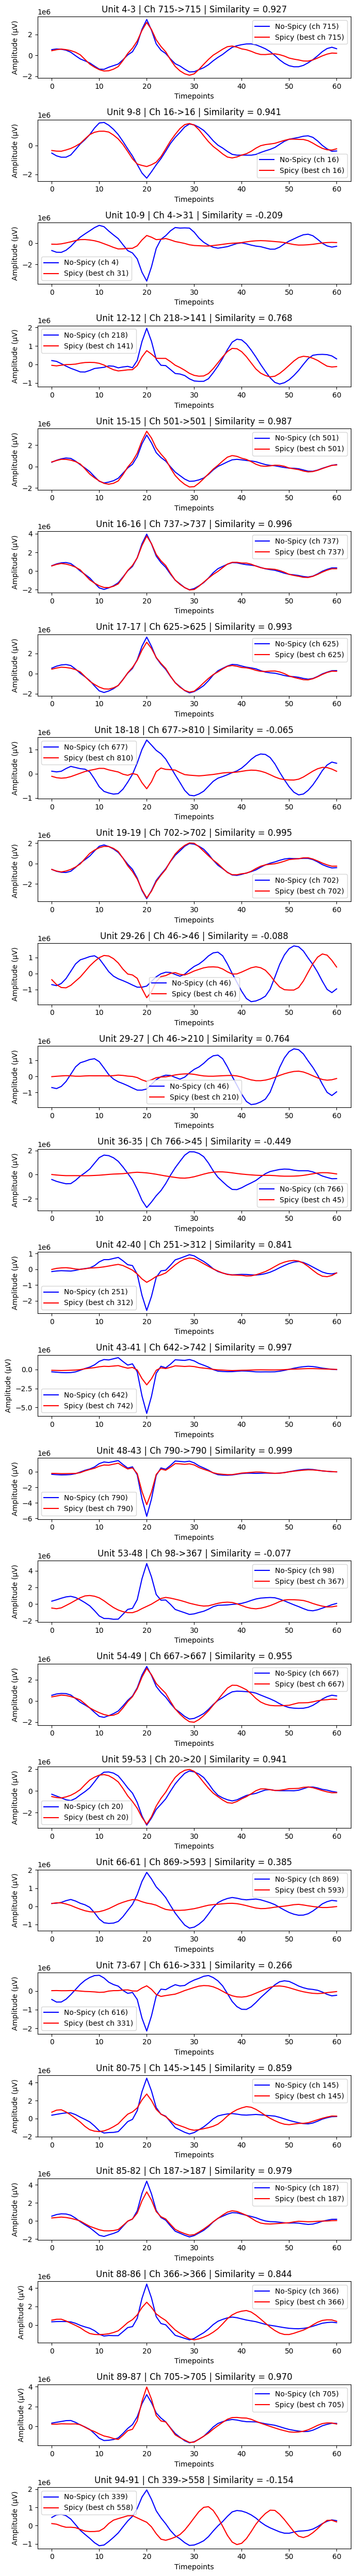

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

def cosine_similarity(a, b):
    a = a - np.mean(a)
    b = b - np.mean(b)
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def best_neighbor_waveform_match(rec1, rec2, matched_units, radius_um=40):
    locs2 = rec2['channel_positions']
    new_matches = []
    similarity_scores = []

    for (u1, u2, ch) in matched_units:
        # Reference waveform (No-Spicy, best channel)
        ch1_best = rec1['chan_best'][u1]
        wv1 = rec1['templates'][u1, :, ch1_best]

        # Spicy: search nearby channels around its best channel
        ch2_best = rec2['chan_best'][u2]
        x2, y2 = locs2[ch2_best]
        dists = np.linalg.norm(locs2 - np.array([x2, y2]), axis=1)
        nearby_chs = np.where(dists <= radius_um)[0]

        # Compare similarity for all nearby channels
        best_score = -1
        best_ch2 = None
        for ch_near in nearby_chs:
            wv2 = rec2['templates'][u2, :, ch_near]
            sim = cosine_similarity(wv1, wv2)
            if sim > best_score:
                best_score = sim
                best_ch2 = ch_near
        
        new_matches.append((u1, u2, ch1_best, best_ch2))
        similarity_scores.append(best_score)
    
    return np.array(new_matches, dtype=object), np.array(similarity_scores)

# --- Example call ---
new_matched_units, sim_scores = best_neighbor_waveform_match(rec1, rec2, matched_units)

# --- Plot both waveforms (using their respective best channels) ---
def plot_best_waveforms(rec1, rec2, matched_units, sim_scores):
    fig, axes = plt.subplots(len(matched_units), 1, figsize=(7, 2 * len(matched_units)))
    if len(matched_units) == 1:
        axes = [axes]

    for i, ((u1, u2, ch1, best_ch2), sim) in enumerate(zip(matched_units, sim_scores)):
        # Plot the actual single-channel waveforms (not averaged)
        wv1 = rec1['templates'][u1, :, ch1] * 1e6
        wv2 = rec2['templates'][u2, :, best_ch2] * 1e6

        ax = axes[i]
        ax.plot(wv1, color='blue', label=f'No-Spicy (ch {ch1})')
        ax.plot(wv2, color='red', label=f'Spicy (best ch {best_ch2})')
        ax.set_title(f"Unit {u1}-{u2} | Ch {ch1}->{best_ch2} | Similarity = {sim:.3f}")
        ax.set_xlabel("Timepoints")
        ax.set_ylabel("Amplitude (µV)")
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_best_waveforms(rec1, rec2, new_matched_units, sim_scores)


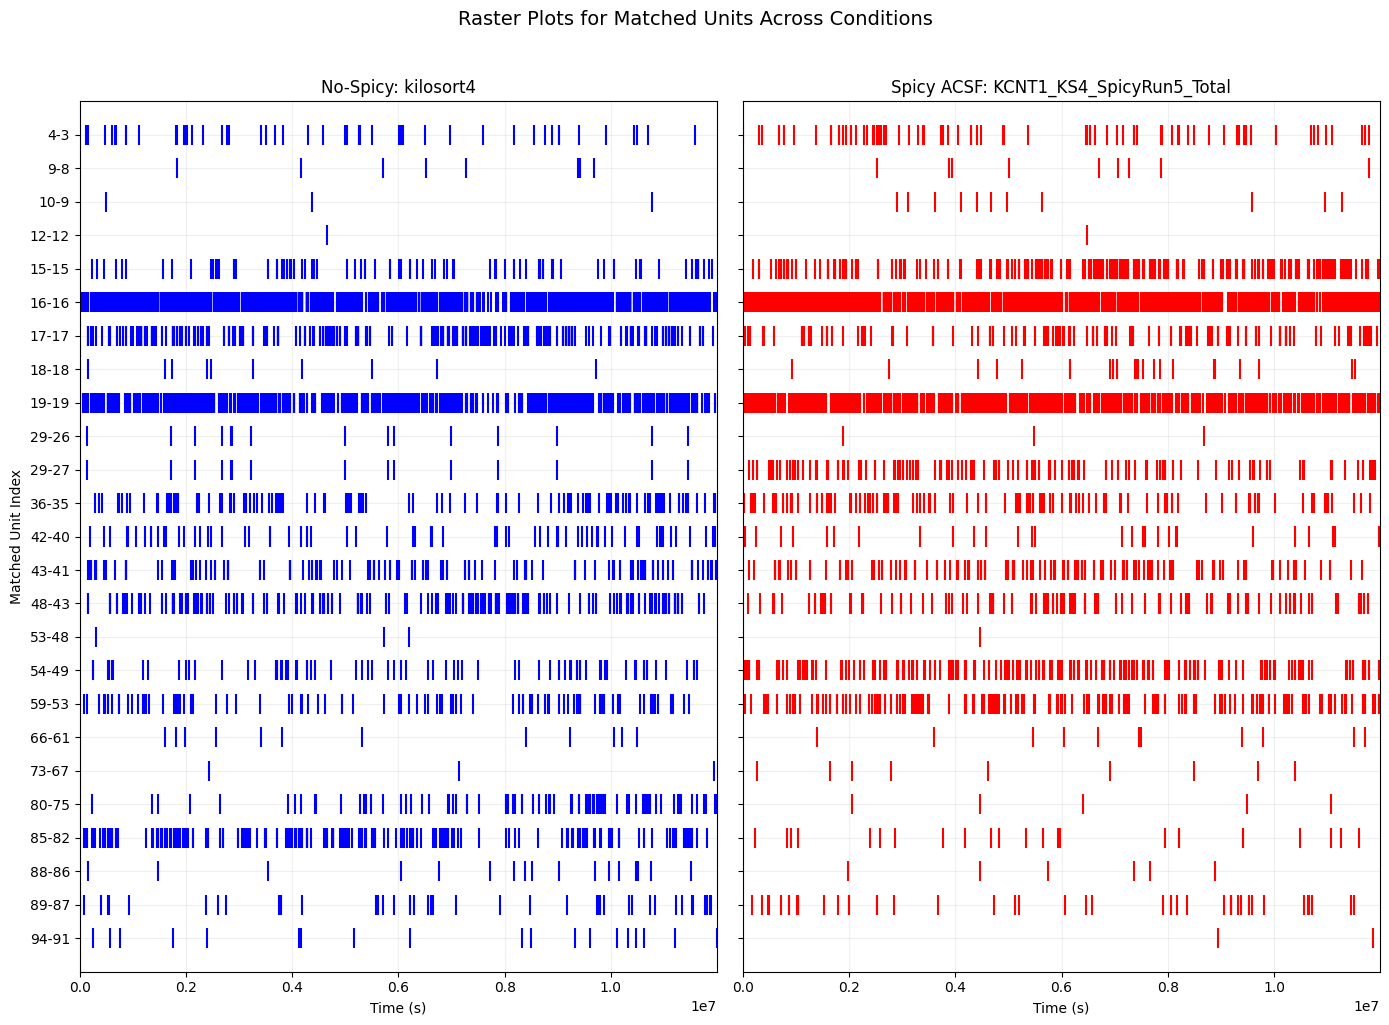

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def get_unit_spikes(spike_times, spike_clusters, unit_id):
    """Return spike times (in seconds) for a given unit."""
    return spike_times[spike_clusters == unit_id]

def plot_matched_rasters(rec1, rec2, matched_units, path_no_spicy, path_spicy):
    """
    Plots rasters for matched units across No-Spicy and Spicy recordings.

    rec1, rec2: dicts with 'spike_times' and 'spike_clusters'
    matched_units: array-like of tuples (u1, u2, ch1, ch2) or (u1, u2, ch1, ch2, rmse)
    path_no_spicy, path_spicy: string or Path (used for titles)
    """
    n_units = len(matched_units)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, max(5, n_units * 0.4)), sharey=True)
    
    # --- Left panel: No-Spicy ---
    for i, unit in enumerate(matched_units):
        u1 = unit[0]  # first element is No-Spicy unit
        times_1 = get_unit_spikes(rec1['spike_times'], rec1['spike_clusters'], u1)
        if len(times_1) > 0:
            axes[0].eventplot(times_1, lineoffsets=i, colors="blue", linelengths=0.6)

    axes[0].set_title(f"No-Spicy: {getattr(path_no_spicy, 'name', str(path_no_spicy))}")
    axes[0].set_xlabel("Time (s)")
    axes[0].set_ylabel("Matched Unit Index")
    axes[0].set_yticks(range(n_units))
    axes[0].set_yticklabels([f"{unit[0]}-{unit[1]}" for unit in matched_units])

    # --- Right panel: Spicy ---
    for i, unit in enumerate(matched_units):
        u2 = unit[1]  # second element is Spicy unit
        times_2 = get_unit_spikes(rec2['spike_times'], rec2['spike_clusters'], u2)
        if len(times_2) > 0:
            axes[1].eventplot(times_2, lineoffsets=i, colors="red", linelengths=0.6)

    axes[1].set_title(f"Spicy ACSF: {getattr(path_spicy, 'name', str(path_spicy))}")
    axes[1].set_xlabel("Time (s)")

    # --- Shared styling ---
    max_time = max(rec1['spike_times'].max(), rec2['spike_times'].max())
    for ax in axes:
        ax.set_xlim(0, max_time)
        ax.set_ylim(-1, n_units)
        ax.invert_yaxis()
        ax.grid(alpha=0.2)

    plt.suptitle("Raster Plots for Matched Units Across Conditions", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

plot_matched_rasters(rec1, rec2, new_matched_units, path_no_spicy, path_spicy)

In [ ]:
'''there are there matched units. 
- i want to take each unit location from no spicy, then use brute force approach to check 2 electrode radius around it (every electrode is 17.5 micrometers apart so 35 micrometers is 2 electrodes)
- if there is a unit detected in spicy acsf within that radius, then i will call it a match and show that dot on this new probe layout with 50% opacity (red) and no spicy will be blue (50% opacity)) 
- then there will be a similarity score (can use rmse values, etc..) to match the waveform of the no spicy unit to spicy unit, the higher the score, the better the match
- the best score within the radius will be the match pair 
- this match pair will then be used for the raster plot and overlapped waveforms 
- '''

In [227]:
# MODULAR VERSION 
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.spatial import distance

def compute_rmse(wv1, wv2):
    return np.sqrt(np.mean((wv1 - wv2)**2))

def brute_force_match(rec1, rec2, good_units_1, good_units_2, radius_um=35):
    matched_units = []
    chan_pos1 = rec1['channel_positions']
    chan_pos2 = rec2['channel_positions']
    
    for u1 in good_units_1:
        ch1 = rec1['chan_best'][u1]
        x1, y1 = chan_pos1[ch1]

        # distance to all spicy channels
        dists = np.linalg.norm(chan_pos2[rec2['chan_best'][good_units_2]] - np.array([x1, y1]), axis=1)
        nearby_idx = np.where(dists <= radius_um)[0]

        if len(nearby_idx) == 0:
            continue  # no nearby unit
        
        # compare waveform similarity for all nearby units
        best_rmse = np.inf
        best_match = None
        
        for idx in nearby_idx:
            u2 = good_units_2[idx]
            wv1 = rec1['templates'][u1, :, :].mean(axis=1)
            wv2 = rec2['templates'][u2, :, :].mean(axis=1)
            rmse = compute_rmse(wv1, wv2)
            if rmse < best_rmse:
                best_rmse = rmse
                best_match = (u1, u2, ch1, rec2['chan_best'][u2], best_rmse)
        
        if best_match:
            matched_units.append(best_match)

    return np.array(matched_units, dtype=object)

matched_units = brute_force_match(rec1, rec2, good_units_1, good_units_2)



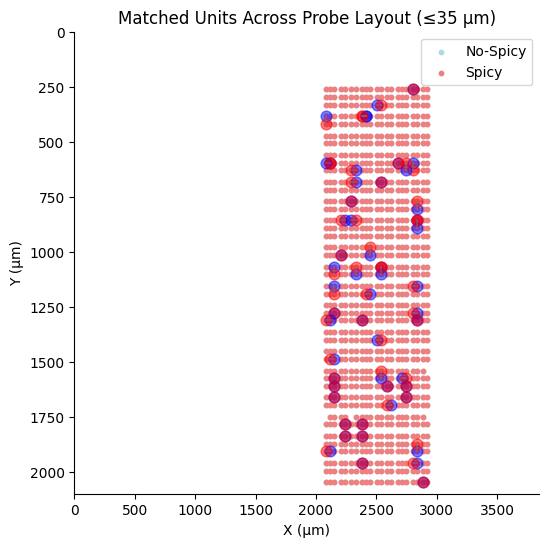

In [229]:
def plot_probe_matches(rec1, rec2, matched_units):
    pos1 = rec1['channel_positions']
    pos2 = rec2['channel_positions']

    plt.figure(figsize=(6,6))
    plt.scatter(pos1[:,0], pos1[:,1], s=10, color='lightblue', label='No-Spicy')
    plt.scatter(pos2[:,0], pos2[:,1], s=10, color='lightcoral', label='Spicy')

    for (u1, u2, ch1, ch2, rmse) in matched_units:
        x1, y1 = pos1[ch1]
        x2, y2 = pos2[ch2]
        plt.plot([x1, x2], [y1, y2], color='gray', alpha=0.4)
        plt.scatter(x1, y1, color='blue', alpha=0.5, s=60)
        plt.scatter(x2, y2, color='red', alpha=0.5, s=60)
    
    plt.title("Matched Units Across Probe Layout (≤35 µm)")
    plt.xlim([0,3850])
    plt.ylim(2100,0)
    plt.xlabel("X (µm)")
    plt.ylabel("Y (µm)")
    plt.legend()
    plt.show()

plot_probe_matches(rec1, rec2, matched_units)


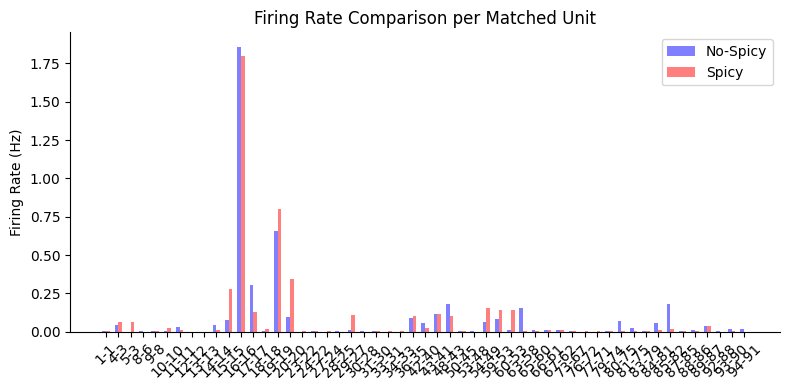

In [233]:
def compute_firing_rate(spike_times, duration_s):
    return len(spike_times) / duration_s

def plot_firing_rates(rec1, rec2, matched_units, fs=recording1.get_sampling_frequency()):
    rates_no = []
    rates_spicy = []
    labels = []

    duration1 = rec1['duration']
    duration2 = rec2['duration']

    for u1, u2, ch1, ch2, _ in matched_units:
        st1 = get_unit_spikes(rec1['spike_times'], rec1['spike_clusters'], u1)
        st2 = get_unit_spikes(rec2['spike_times'], rec2['spike_clusters'], u2)
        rates_no.append(compute_firing_rate(st1, duration1))
        rates_spicy.append(compute_firing_rate(st2, duration2))
        labels.append(f"{u1}-{u2}")
    
    plt.figure(figsize=(8,4))
    plt.bar(np.arange(len(labels)) - 0.15, rates_no, 0.3, color='blue', alpha=0.5, label='No-Spicy')
    plt.bar(np.arange(len(labels)) + 0.15, rates_spicy, 0.3, color='red', alpha=0.5, label='Spicy')
    plt.xticks(range(len(labels)), labels, rotation=45)
    plt.ylabel("Firing Rate (Hz)")
    plt.title("Firing Rate Comparison per Matched Unit")
    plt.legend()
    plt.tight_layout()
    plt.show()


rec1['duration'] = recording1.get_total_duration()  # in seconds
rec2['duration'] = recording1.get_total_duration()  # in seconds
plot_firing_rates(rec1, rec2, matched_units)    

In [242]:
def compute_firing_rate(spike_times, spike_clusters, unit_id, total_time_s):
    return np.sum(spike_clusters == unit_id) / total_time_s

total_time_no_spicy = rec1['spike_times'].max() / fs
total_time_spicy = rec2['spike_times'].max() / fs

fr_diff = []
for (u1, u2, _, _, rmse) in matched_units:
    fr1 = compute_firing_rate(rec1['spike_times'], rec1['spike_clusters'], u1, total_time_no_spicy)
    fr2 = compute_firing_rate(rec2['spike_times'], rec2['spike_clusters'], u2, total_time_spicy)
    fr_diff.append((u1, u2, fr1, fr2, fr2-fr1))

fr_df = pd.DataFrame(fr_diff, columns=["Unit_NoSpicy", "Unit_Spicy", "FR_NoSpicy", "FR_Spicy", "ΔFR"])
display(fr_df)


Unit_NoSpicy  Unit_Spicy  FR_NoSpicy  FR_Spicy           ΔFR
0              1           1    0.002501  0.003336  8.349472e-04
1              4           3    0.041688  0.062554  2.086627e-02
2              5           3    0.000834  0.062554  6.172062e-02
3              8           6    0.005836  0.001668 -4.168219e-03
4              9           8    0.006670  0.007507  8.364284e-04
5             10          10    0.002501  0.023354  2.085235e-02
6             11          11    0.031683  0.014179 -1.750397e-02
7             12          12    0.000834  0.000834  2.962432e-07
8             13          13    0.000834  0.001668  8.343547e-04
9             14          14    0.044189  0.014179 -3.001040e-02
10            15          15    0.075872  0.280244  2.043713e-01
11            16          16    1.860957  1.800732 -6.022505e-02
12            17          17    0.303489  0.127611 -1.758785e-01
13            18          18    0.008338  0.020017  1.167978e-02
14            19          19    0.655337  0.804032  1.486953e-01
15            20          20    0.094215  0.343632  2.494170e-01
16            23          22    0.001668  0.007507  5.839002e-03
17            24          22    0.004169  0.007507  3.337715e-03
18            27          24    0.001668  0.002502  8.346510e-04
19            28          25    0.002501  0.001668 -8.331697e-04
20            29          27    0.012506  0.110930  9.842334e-02
21            30          28    0.005836  0.001668 -4.168219e-03
22            31          30    0.002501  0.005838  3.337123e-03
23            33          31    0.000834  0.002502  1.668413e-03
24            34          33    0.000834  0.003336  2.502472e-03
25            36          35    0.090880  0.100087  9.206934e-03
26            42          40    0.057530  0.024188 -3.334190e-02
27            43          41    0.115893  0.117602  1.709295e-03
28            48          43    0.180926  0.101755 -7.917127e-02
29            50          45    0.002501  0.003336  8.349472e-04
30            53          48    0.002501  0.000834 -1.667228e-03
31            54          49    0.064200  0.154301  9.010113e-02
32            59          53    0.081709  0.141790  6.008124e-02
33            60          53    0.011673  0.141790  1.301173e-01
34            63          58    0.155080  0.002502 -1.525776e-01
35            65          60    0.013340  0.002502 -1.083802e-02
36            66          61    0.010005  0.009175 -8.305036e-04
37            67          62    0.012506  0.012511  4.443647e-06
38            73          67    0.002501  0.007507  5.005240e-03
39            76          72    0.000834  0.002502  1.668413e-03
40            77          71    0.001668  0.004170  2.502768e-03
41            79          74    0.005836  0.004170 -1.666043e-03
42            80          75    0.070870  0.004170 -6.669950e-02
43            81          75    0.025013  0.004170 -2.084257e-02
44            83          79    0.005836  0.005004 -8.319848e-04
45            84          81    0.057530  0.010843 -4.668683e-02
46            85          82    0.184261  0.020017 -1.642441e-01
47            87          85    0.004169  0.002502 -1.666636e-03
48            88          86    0.014174  0.005004 -9.169607e-03
49            89          87    0.035852  0.036699  8.467969e-04
50            92          88    0.006670  0.000834 -5.836039e-03
51            93          90    0.019177  0.003336 -1.584030e-02
52            94          91    0.015841  0.001668 -1.417337e-02

In [85]:
fs = recording1.get_sampling_frequency()  # or your actual sampling rate
duration_sec = rec1['spike_times'].max() / fs
print(duration_sec)


1199.3827


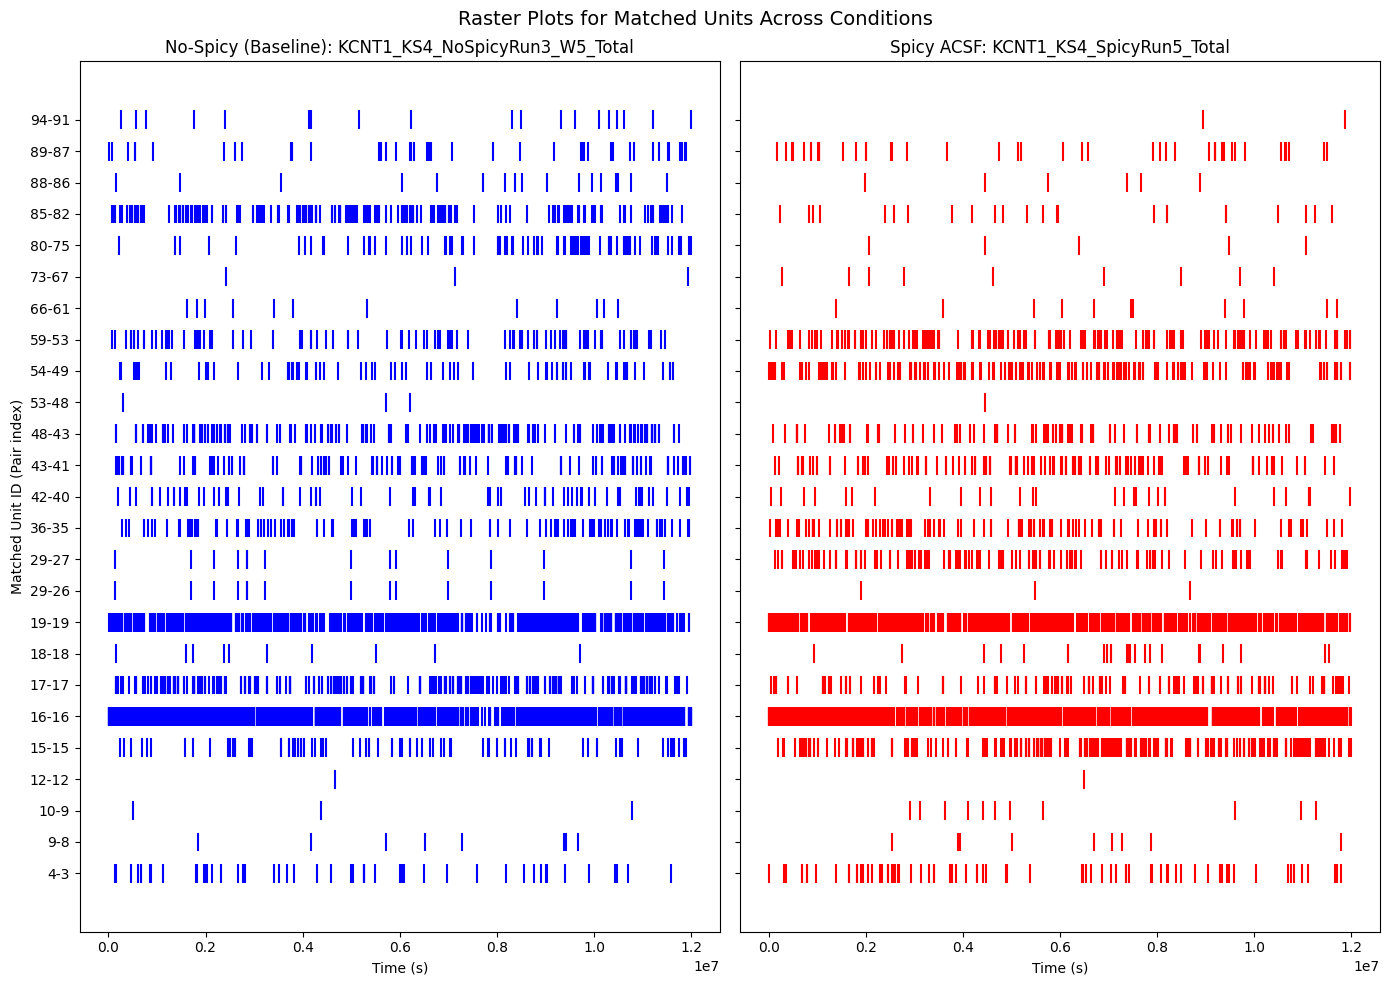

In [41]:
# Filter to matched units only
matched_units_list = matched_units.tolist()

fig, axes = plt.subplots(1, 2, figsize=(14, 10), sharey=True)

# ---- Left: No-Spicy ----
for i, (u1, u2, ch) in enumerate(matched_units_list):
    times_1 = get_unit_spikes(rec1['spike_times'], rec1['spike_clusters'], u1)
    axes[0].eventplot(times_1, lineoffsets=i, colors="blue", linelengths=0.6)
axes[0].set_title(f"No-Spicy (Baseline): {path_no_spicy.parts[-2]}")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Matched Unit ID (Pair index)")
axes[0].set_yticks(range(len(matched_units_list)))
axes[0].set_yticklabels([f"{u1}-{u2}" for (u1, u2, _) in matched_units_list])


# ---- Right: Spicy ----
for i, (u1, u2, ch) in enumerate(matched_units_list):
    times_2 = get_unit_spikes(rec2['spike_times'], rec2['spike_clusters'], u2)
    axes[1].eventplot(times_2, lineoffsets=i, colors="red", linelengths=0.6)
axes[1].set_title(f"Spicy ACSF: {path_spicy.name}")
axes[1].set_xlabel("Time (s)")

plt.suptitle(f"Raster Plots for Matched Units Across Conditions", fontsize=14)

plt.tight_layout()
plt.show()


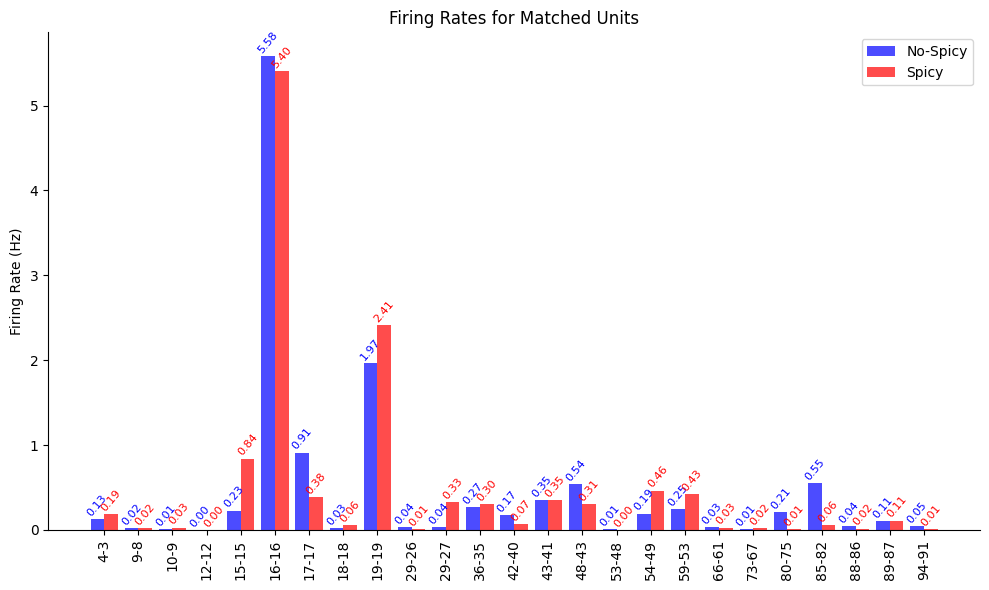

<Figure size 640x480 with 0 Axes>

In [192]:
# Extract firing rates for matched units
no_spicy_firing_rates = [rec1['firing_rates'][u1] for u1, _, _ in matched_units]
spicy_firing_rates = [rec2['firing_rates'][u2] for _, u2, _ in matched_units]

# Print the firing rates
# for i, (u1, u2, _) in enumerate(matched_units):
#     print(f"No-Spicy Unit {u1} {no_spicy_firing_rates[i]:.4f}"
#           f"Spicy Unit {u2} {spicy_firing_rates[i]:.4f}") 
    
# Create a DataFrame with No-Spicy and Spicy firing rates
fr_df = pd.DataFrame({
    'No-Spicy': no_spicy_firing_rates,
    'Spicy': spicy_firing_rates
})

# Display the first few rows of the DataFrame
fr_df
# Create a single plot for all matched units
fig, ax = plt.subplots(figsize=(10, 6))

# Loop through matched units and plot their firing rates
for i, (u1, u2, _) in enumerate(matched_units):
    ax.bar(
        [i - 0.2, i + 0.2],  # Adjust bar positions for No-Spicy and Spicy
        [rec1['firing_rates'][u1], rec2['firing_rates'][u2]],
        width=0.4,
        color=['blue', 'red'],
        alpha=0.7,
        label=['No Spicy', 'Spicy']
    )

# Customize the plot
ax.set_xticks(range(len(matched_units)))
ax.set_xticklabels([f'{u1}-{u2}' for u1, u2, _ in matched_units], rotation=90)
ax.set_ylabel('Firing Rate (Hz)')
ax.set_title('Firing Rates for Matched Units')
ax.legend(['No-Spicy', 'Spicy'], loc='upper right')
# Add firing rate values on top of each bar
for i, (u1, u2, _) in enumerate(matched_units):
    ax.text(i - 0.2, rec1['firing_rates'][u1] + 0.01, 
            f"{rec1['firing_rates'][u1]:.2f}", 
            ha='center', va='bottom', rotation=50, fontsize=8, color='blue')
    ax.text(i + 0.2, rec2['firing_rates'][u2] + 0.01, 
            f"{rec2['firing_rates'][u2]:.2f}", 
            ha='center', va='bottom', rotation=50, fontsize=8, color='red')
plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

In [176]:
# Add a new column for unit ID pairs
fr_df.insert(0, 'Unit ID Pair', [f'{u1}-{u2}' for u1, u2, _ in matched_units])
fr_df

Unit ID Pair  No-Spicy     Spicy
0           4-3  0.125064  0.187663
1           9-8  0.020010  0.022520
2          10-9  0.007504  0.027524
3         12-12  0.002501  0.002502
4         15-15  0.227617  0.840731
5         16-16  5.582872  5.402197
6         17-17  0.910468  0.382833
7         18-18  0.025013  0.060052
8         19-19  1.966011  2.412097
9         29-26  0.037519  0.007507
10        29-27  0.037519  0.332789
11        36-35  0.272640  0.300261
12        42-40  0.172589  0.072563
13        43-41  0.347679  0.352807
14        48-43  0.542779  0.305265
15        53-48  0.007504  0.002502
16        54-49  0.192599  0.462902
17        59-53  0.245126  0.425370
18        66-61  0.030015  0.027524
19        73-67  0.007504  0.022520
20        80-75  0.212609  0.012511
21        85-82  0.552784  0.060052
22        88-86  0.042522  0.015013
23        89-87  0.107555  0.110096
24        94-91  0.047524  0.005004

In [163]:
unit_id = 15  # example
best_chan = chan_best[unit_id]  # index of best channel

# Get electrode coordinates from the recording
locs = recording1.get_channel_locations()  # shape: (n_channels, 2)
x, y = locs[best_chan]
print(f"Unit {unit_id} best channel: {best_chan}, location: x={x:.1f} µm, y={y:.1f} µm")


Unit 15 best channel: 818, location: x=2450.0 µm, y=1960.0 µm


In [83]:
print(recording1)

MaxwellRecordingExtractor: 899 channels - 10.0kHz - 1 segments - 12,000,400 samples 
                           1,200.04s (20.00 minutes) - uint16 dtype - 20.09 GiB
  file_path: /mnt/disk20tb/shruti/KCNT1_MEASlices/KCNT1_MEASlices_250606/M07896/Network/000005/data.raw.h5


In [132]:
#** TESTING THE ELECTRODES MAPPING **#
# Initialize the electrodes list
electrodes = []
channel_location_dict = {}

# Get channel IDs and locations
channel_ids = recording1.get_channel_ids()
locations = recording1.get_channel_locations()

print(channel_ids)
print( f"{x}" for x, y in locations)
# Populate the electrodes list
for channel, loc in zip(channel_ids, locations):
    # Calculate electrode ID based on location
    electrode_id = 220 * int(loc[1] / 17.5) + int(loc[0] / 17.5)
    electrodes.append(electrode_id)
    channel_location_dict[channel] = electrode_id  # Map channel to electrode

# Validate the electrodes list
if len(electrodes) != len(channel_ids):
    print(f"Warning: Mismatch between number of channels ({len(channel_ids)}) and electrodes ({len(electrodes)}).")
else:
    print(f"Successfully mapped {len(electrodes)} electrodes.")

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '25' '26' '27' '28' '29' '30'
 '31' '32' '33' '34' '35' '37' '38' '39' '40' '41' '42' '43' '44' '45'
 '46' '47' '48' '49' '50' '51' '53' '54' '55' '56' '57' '58' '59' '60'
 '61' '62' '63' '64' '65' '66' '67' '68' '69' '70' '71' '72' '73' '74'
 '75' '76' '77' '78' '79' '81' '82' '83' '84' '85' '86' '87' '88' '89'
 '90' '91' '93' '94' '95' '97' '98' '99' '100' '101' '102' '103' '105'
 '106' '107' '108' '109' '110' '111' '112' '113' '114' '115' '116' '117'
 '118' '119' '121' '122' '123' '125' '126' '127' '129' '130' '131' '133'
 '134' '135' '137' '138' '139' '141' '142' '143' '145' '146' '147' '149'
 '150' '151' '153' '154' '155' '157' '158' '159' '161' '162' '163' '165'
 '166' '167' '169' '170' '171' '173' '174' '175' '177' '178' '179' '181'
 '182' '183' '185' '186' '187' '189' '190' '191' '193' '194' '195' '197'
 '198' '199' '201' '202' '203' '205' '206' '207' '209' '210' '211

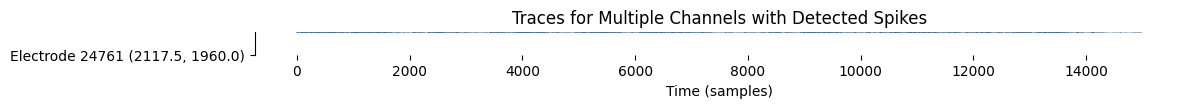

In [133]:
import os

import numpy as np
import matplotlib.pyplot as plt

plt.close('all')  # Close all existing figures to prevent multiple plots

# Define the detect_peaks_stddev function
def detect_peaks_stddev(trace, peak_sign, std_multiplier):
    """
    Detect peaks in a signal based on standard deviation thresholding.

    Parameters:
    - trace: 1D numpy array, the signal to analyze
    - peak_sign: str, "pos" for positive peaks, "neg" for negative peaks
    - std_multiplier: float, the threshold multiplier for peak detection

    Returns:
    - peaks: numpy array, indices of detected peaks
    - threshold: float, the threshold value used for detection
    """
    mean = np.mean(trace)
    std = np.std(trace)
    threshold = mean + std_multiplier * std if peak_sign == "pos" else mean - std_multiplier * std

    if peak_sign == "pos":
        peaks = np.where((trace[1:-1] > trace[:-2]) & (trace[1:-1] > trace[2:]) & (trace[1:-1] > threshold))[0] + 1
    elif peak_sign == "neg":
        peaks = np.where((trace[1:-1] < trace[:-2]) & (trace[1:-1] < trace[2:]) & (trace[1:-1] < threshold))[0] + 1
    else:
        raise ValueError("peak_sign must be 'pos' or 'neg'")

    return peaks, threshold
%matplotlib inline
# Ensure channels_to_plot only contains valid indices within the bounds of the traces array
channels_to_plot = [818]
fs = recording1.get_sampling_frequency()
start_time = 400 # Start time in seconds
end_time = 401.5 # End time in seconds
# Get traces for the specified range
traces = recording1.get_traces(start_frame=int(start_time*fs), end_frame=int(end_time*fs), segment_index=0, return_scaled=True)

# Define the channels you want to plot
 # Replace with the desired channel indices
#channels_to_plot = range(traces.shape[1])  # Example channel indices
# Parameters for spike detection
peak_sign = "neg"  # Detect negative peaks
std_multiplier = 4 # Threshold: 1 standard deviation from the mean

# Adjust figure height dynamically based on the number of channels
plt.figure(figsize=(12, len(channels_to_plot) * 0.3))  # Increase height for better spacing

# Extract channel IDs and 2D location coordinates
channel_ids = np.array([int(x) for x in recording1.get_channel_ids()])
locs = recording1.get_channel_locations()  # Define locs here
# Ensure channels_to_plot only contains valid indices within the bounds of the traces array
channels_to_plot_indices = [np.where(channel_ids == ch)[0][0] for ch in channels_to_plot if ch in channel_ids]

# Loop through the channels and plot each
yticks_positions = []  # Store y-axis positions for labeling
yticks_labels = []  # Store channel names for labeling

spike_times_channel = {} # Store spike times for each channel
for i, channel_idx in enumerate(channels_to_plot_indices):
    # Get the trace for the current channel
    trace = traces[:, channel_idx]
    
    # Detect peaks using the detect_peaks function
    peaks_sample_inds, _ = detect_peaks_stddev(trace, peak_sign, std_multiplier)

    
    # Convert peaks_sample_inds to integers
    peaks_sample_inds = peaks_sample_inds.astype(int)
    spike_times_channel[channel] = peaks_sample_inds  # Store spike times for the channel

    spike_marker_offset = 100
    
    # Plot the trace with increased spacing
    plt.plot(
        trace + i * 200,  # Increase the offset to 200 for better spacing
        label=f'Electrode {electrodes[channel_idx]}',  # Use the actual channel ID for labeling
        rasterized=True,  # Rasterize the line plots for faster rendering
        linewidth=0.5  # Use thinner lines for better performance
    )
    
    # Mark the detected spikes with red triangles
    plt.plot(
        peaks_sample_inds, 
        trace[peaks_sample_inds] + i * 200 + spike_marker_offset,  # Match the increased offset
        'rv',  # Red triangles
        markersize=4, 
        label=f'Spikes Channel {electrodes[channel_idx]}'
    )
    
    # Add y-axis tick position and label
    yticks_positions.append(i * 200)
    
    # Retrieve the x, y coordinates for the channel
    x, y = locs[channel_idx]  # Use the index to get the location
    yticks_labels.append(f'Electrode {electrodes[channel_idx]} ({x:.1f}, {y:.1f})')  # Format with coordinates

# Customize the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Time (samples)')
plt.title('Traces for Multiple Channels with Detected Spikes')

# Add y-axis ticks with channel names and coordinates
plt.yticks(yticks_positions, yticks_labels)

# Save the plot as a PDF
output_path = './savetraces_multiple_channels_with_spikes.pdf'  # Replace with your desired path
plt.show() 
plt.savefig(output_path, format='pdf', bbox_inches='tight', dpi=150)  # Save with high resolution
plt.close()  # Close the plot to free memory

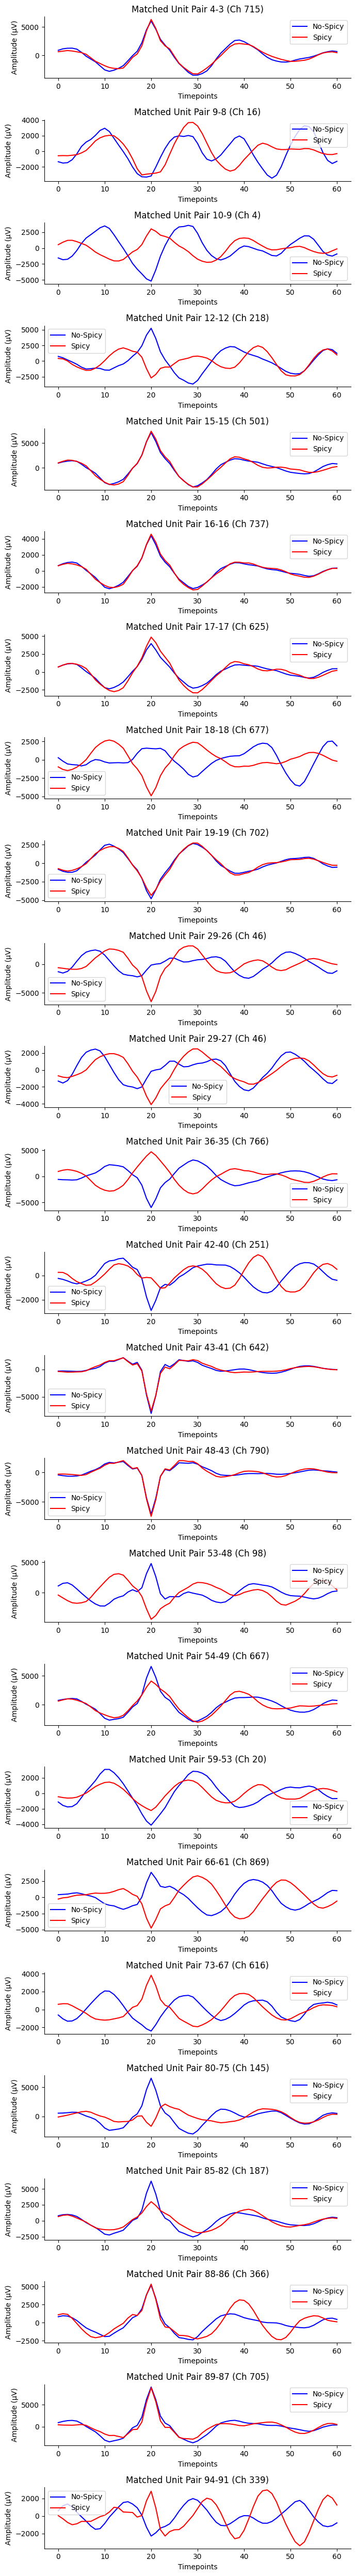

In [134]:
def plot_avg_waveforms(rec1, rec2, matched_units):
    fig, axes = plt.subplots(len(matched_units), 1, figsize=(7, 2*len(matched_units)))
    if len(matched_units) == 1:
        axes = [axes]
    
    for i, (u1, u2, ch) in enumerate(matched_units):
        wv1 = rec1['templates'][u1, :, :].mean(axis=1) * 1e6  # Convert to µV
        wv2 = rec2['templates'][u2, :, :].mean(axis=1) * 1e6  # Convert to µV
        
        ax = axes[i]
        ax.plot(wv1, color='blue', label='No-Spicy')
        ax.plot(wv2, color='red', label='Spicy')
        ax.set_title(f"Matched Unit Pair {u1}-{u2} (Ch {ch})")
        ax.set_xlabel("Timepoints")
        ax.set_ylabel("Amplitude (µV)")
        ax.legend()
    
    plt.tight_layout()
    plt.show()

plot_avg_waveforms(rec1, rec2, matched_units)


In [93]:
summary_data = []

for (u1, u2, ch) in matched_units:
    entry = {
        'Channel': ch,
        'NoSpicy_Unit': u1,
        'Spicy_Unit': u2,
        'NoSpicy_Amplitude': rec1['amplitude_stats'][u1] if rec1['amplitude_stats'] is not None else np.nan,
        'Spicy_Amplitude': rec2['amplitude_stats'][u2] if rec2['amplitude_stats'] is not None else np.nan,
        'NoSpicy_FiringRate_Hz': rec1['firing_rates'][u1] if len(rec1['firing_rates']) > u1 else np.nan,
        'Spicy_FiringRate_Hz': rec2['firing_rates'][u2] if len(rec2['firing_rates']) > u2 else np.nan,
        'NoSpicy_ContamPct': rec1['contam_pct'][u1] if rec1['contam_pct'] is not None else np.nan,
        'Spicy_ContamPct': rec2['contam_pct'][u2] if rec2['contam_pct'] is not None else np.nan,
    }
    summary_data.append(entry)

summary_df = pd.DataFrame(summary_data)
summary_df


Channel  NoSpicy_Unit  Spicy_Unit  NoSpicy_Amplitude  Spicy_Amplitude  \
0       715             4           3                9.1              8.8   
1        16             9           8                9.9              8.3   
2         4            10           9               11.1              9.6   
3       218            12          12               13.3             12.3   
4       501            15          15                9.0              9.4   
5       737            16          16                9.2              9.2   
6       625            17          17                9.2              9.3   
7       677            18          18                8.0              9.5   
8       702            19          19                9.0              9.0   
9        46            29          26                9.1             10.5   
10       46            29          27                9.1              9.3   
11      766            36          35                8.8              8.9   
12      642            43          41                9.8              9.6   
13      790            48          43                9.3              8.7   
14       98            53          48               12.0             13.0   
15      667            54          49                8.8              8.6   
16       20            59          53                8.9              8.9   
17      869            66          61                8.2              9.3   
18      616            73          67                9.5              8.8   
19      145            80          75                8.9             10.5   
20      187            85          82                8.9              8.5   
21      366            88          86                9.3              9.8   
22      705            89          87                9.0              9.0   
23      339            94          91                8.8             12.6   

    NoSpicy_FiringRate_Hz  Spicy_FiringRate_Hz  NoSpicy_ContamPct  \
0                0.125064             0.187663                0.0   
1                0.020010             0.022520                0.0   
2                0.007504             0.027524                0.0   
3                0.002501             0.002502                0.0   
4                0.227617             0.840731                0.0   
5                5.582872             5.402197                0.0   
6                0.910468             0.382833                0.0   
7                0.025013             0.060052                0.0   
8                1.966011             2.412097                0.0   
9                0.037519             0.007507                0.0   
10               0.037519             0.332789                0.0   
11               0.272640             0.300261                0.0   
12               0.347679             0.352807                0.0   
13               0.542779             0.305265                0.0   
14               0.007504             0.002502                0.0   
15               0.192599             0.462902                0.0   
16               0.245126             0.425370                0.0   
17               0.030015             0.027524                0.0   
18               0.007504             0.022520                0.0   
19               0.212609             0.012511                0.0   
20               0.552784             0.060052                0.0   
21               0.042522             0.015013                0.0   
22               0.107555             0.110096                0.0   
23               0.047524             0.005004                0.0   

    Spicy_ContamPct  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  
5               0.0  
6               0.0  
7               0.0  
8               0.0  
9               0.0  
10              0.0  
11              0.0  
12              0.0  
13              0.0  
14              0.0  


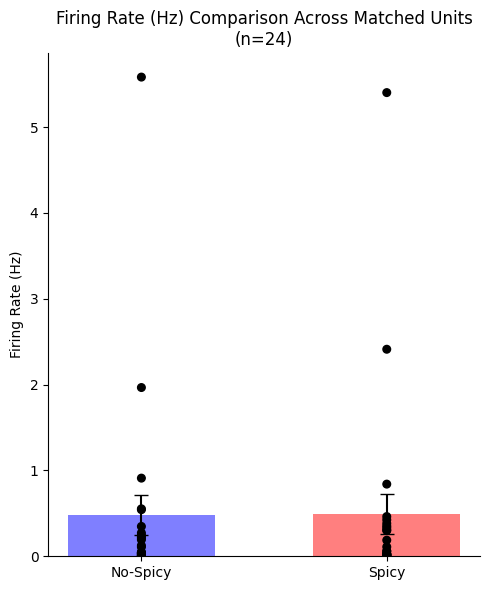

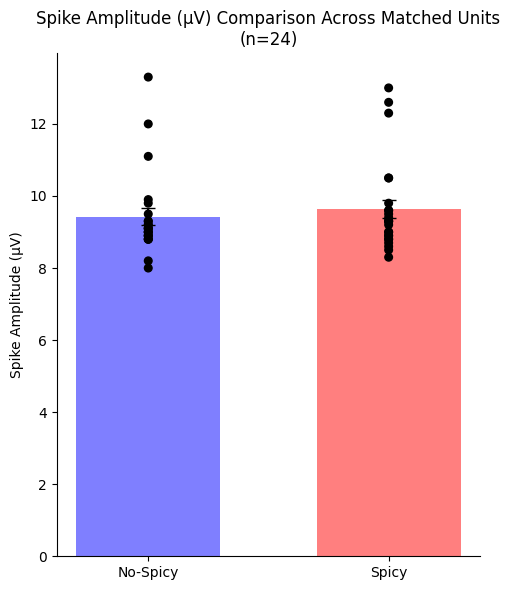

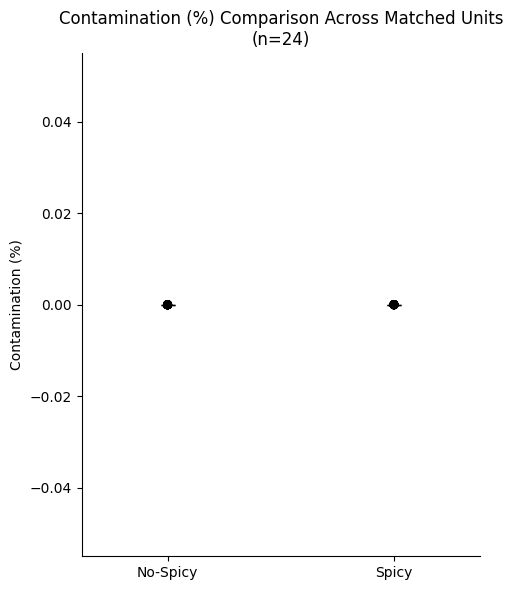

In [94]:
import matplotlib.pyplot as plt
import numpy as np

def paired_barplot(df, metric, label, color1='blue', color2='red'):
    x = np.arange(len(df))  # unit indices
    values_1 = df[f'NoSpicy_{metric}'].values
    values_2 = df[f'Spicy_{metric}'].values

    mean1, mean2 = np.nanmean(values_1), np.nanmean(values_2)
    sem1, sem2 = np.nanstd(values_1)/np.sqrt(len(values_1)), np.nanstd(values_2)/np.sqrt(len(values_2))

    fig, ax = plt.subplots(figsize=(5,6))

    # bars
    ax.bar([0,1], [mean1, mean2],
           yerr=[sem1, sem2],
           capsize=5,
           color=[color1, color2],
           alpha=0.5,
           width=0.6,
           label=['No-Spicy', 'Spicy'])

    # paired scatter + lines
    for i in range(len(df)):
        ax.plot([0,1], [values_1[i], values_2[i]], color='gray', alpha=0.6, lw=0)
        ax.scatter([0,1], [values_1[i], values_2[i]],
                   color=['black','black'], s=30, zorder=3)

    ax.set_xticks([0,1])
    ax.set_xticklabels(['No-Spicy','Spicy'])
    ax.set_ylabel(label)
    ax.set_title(f"{label} Comparison Across Matched Units\n(n={len(df)})")
    plt.tight_layout()
    plt.show()

paired_barplot(summary_df, 'FiringRate_Hz', 'Firing Rate (Hz)')
paired_barplot(summary_df, 'Amplitude', 'Spike Amplitude (µV)')
paired_barplot(summary_df, 'ContamPct', 'Contamination (%)')



/tmp/ipykernel_2171972/4287525050.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
/tmp/ipykernel_2171972/4287525050.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


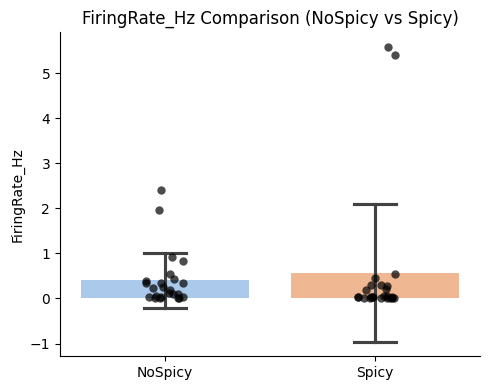

/tmp/ipykernel_2171972/4287525050.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
/tmp/ipykernel_2171972/4287525050.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


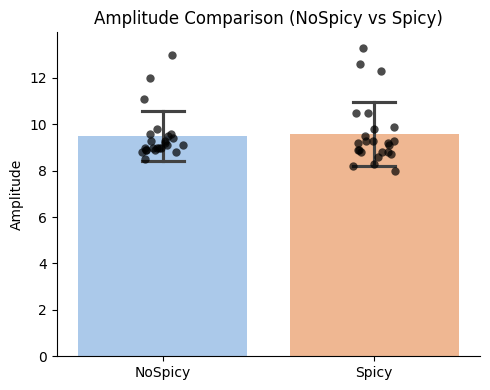

/tmp/ipykernel_2171972/4287525050.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
/tmp/ipykernel_2171972/4287525050.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


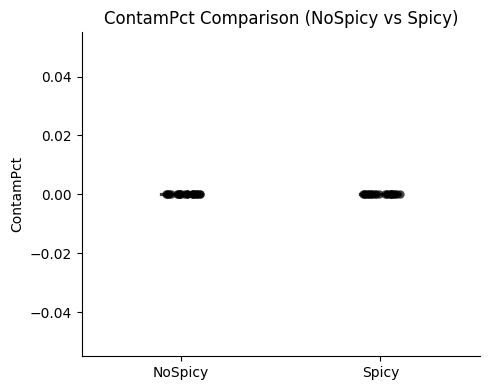

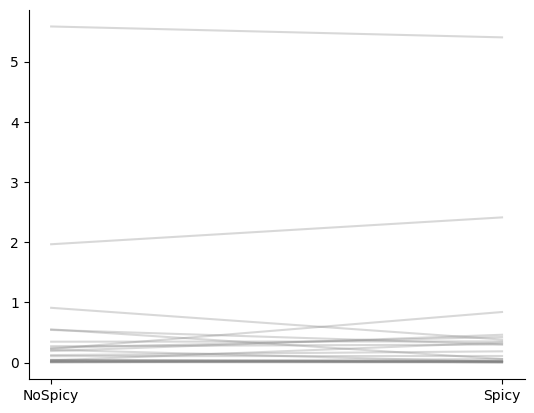

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Example DataFrame
# summary_df = your DataFrame as you defined above

metrics = ['FiringRate_Hz', 'Amplitude', 'ContamPct']

# Reshape into long format for plotting
plot_df = pd.DataFrame({
    'Channel': np.repeat(summary_df['Channel'], 2),
    'Condition': ['NoSpicy', 'Spicy'] * len(summary_df),
    'FiringRate_Hz': np.concatenate([summary_df['NoSpicy_FiringRate_Hz'], summary_df['Spicy_FiringRate_Hz']]),
    'Amplitude': np.concatenate([summary_df['NoSpicy_Amplitude'], summary_df['Spicy_Amplitude']]),
    'ContamPct': np.concatenate([summary_df['NoSpicy_ContamPct'], summary_df['Spicy_ContamPct']]),
})

# Plot each metric
for metric in metrics:
    plt.figure(figsize=(5, 4))
    sns.barplot(
        data=plot_df, 
        x='Condition', y=metric, 
        ci='sd', 
        capsize=0.2, 
        palette=['#a1c9f4', '#ffb482']
    )

    # Add individual points (each matched pair)
    sns.stripplot(
        data=plot_df, 
        x='Condition', y=metric, 
        color='black', size=6, jitter=True, alpha=0.7
    )

    plt.title(f'{metric} Comparison (NoSpicy vs Spicy)')
    plt.ylabel(metric)
    plt.xlabel('')
    plt.tight_layout()
    plt.show()
for _, row in summary_df.iterrows():
    plt.plot(['NoSpicy', 'Spicy'], 
             [row['NoSpicy_FiringRate_Hz'], row['Spicy_FiringRate_Hz']], 
             color='gray', alpha=0.3)


In [39]:
from scipy.stats import ttest_rel

for metric in ['FiringRate_Hz', 'Amplitude', 'ContamPct']:
    a = summary_df[f'NoSpicy_{metric}'].dropna()
    b = summary_df[f'Spicy_{metric}'].dropna()
    t,p = ttest_rel(a,b)
    print(f"{metric}: t={t:.2f}, p={p:.4f}")


FiringRate_Hz: t=1.70, p=0.1396
Amplitude: t=-2.12, p=0.0783
ContamPct: t=nan, p=nan
